# CTCF patterns on genes

In [107]:
import src
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from pybedtools.bedtool import BedTool
from pybedtools import cleanup
cleanup()

figure_path = src.figures_path / "genes"
os.makedirs(figure_path, exist_ok=True)

## Load gene expression dataset
And stratify by RPKM

In [72]:
rpkm_columns = ['RPKM_6124', 'RPKM_7165', 'RPKM_bc27_D6_DMSO', 'RPKM_bc28_D6_DMSO']

genexp = pd.read_csv(src.processed_data_path / "gene_expression_MoMaTA_RNAseq.tsv", sep="\t")
genexp = genexp[src.coords + ['strand', 'gene'] + rpkm_columns]
genexp['gene_uid'] = genexp.index

genexp['mean_RPKM'] = genexp[rpkm_columns].mean(1)
genexp['std_RPKM'] = genexp[rpkm_columns].std(1)

genexp['rpkm_class'] = genexp.mean_RPKM.map(src.rpkm_to_class)
genexp['rpkm_class_name'] = genexp.rpkm_class.map(src.rpkm_class_to_name)

genexp.head()

chr  start    end strand        gene  RPKM_6124  RPKM_7165  \
0  chr1  11869  14412      +     DDX11L1   0.045055   0.118216   
1  chr1  14363  29806      -      WASH7P   4.313933   5.787671   
2  chr1  29554  31109      +  MIR1302-10   0.000589   0.000605   
3  chr1  34554  36081      -     FAM138A   0.000245   0.000455   
4  chr1  52473  54936      +      OR4G4P   0.000289   0.000224   

   RPKM_bc27_D6_DMSO  RPKM_bc28_D6_DMSO  gene_uid  mean_RPKM  std_RPKM  \
0           0.010562           0.062163         0   0.058999  0.044934   
1           4.241810           2.292184         1   4.158899  1.433926   
2           0.001523           0.000879         2   0.000899  0.000437   
3           0.002638           0.000377         3   0.000929  0.001143   
4           0.000717           0.000532         4   0.000441  0.000227   

   rpkm_class rpkm_class_name  
0           0        $[0; 1[$  
1           1       $[1; 10[$  
2           0        $[0; 1[$  
3           0        $[0; 1[$  
4           0        $[0; 1[$

#### How many genes for every RPKM class?

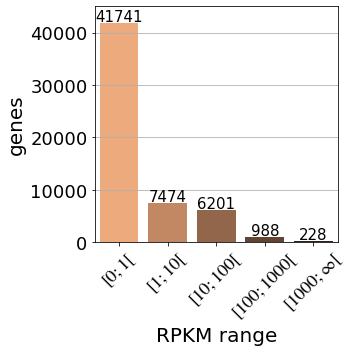

In [74]:
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(genexp.rpkm_class_name, palette="copper_r")
for p in ax.patches:
    plt.text(x=p.get_x() + 0.4, y=p.get_height()+400, s=str(p.get_height()), ha='center', fontsize=15)
plt.ylim(0, 45000)
plt.xticks(rotation=45)
plt.xlabel("RPKM range", fontsize=20)
plt.ylabel("genes", fontsize=20)
plt.grid(axis='y')
fig.savefig(figure_path / "rpkm_range_vs_count.pdf", bbox_inches='tight', transparent=True)
plt.show()

In [142]:
ctcfs = pd.read_csv(src.interim_data_path / "ctcfs_with_context.tsv", sep="\t")
ctcfs = pd.concat((ctcfs, pd.get_dummies(ctcfs[['orientation','context']], prefix="", prefix_sep="")), axis=1)
ctcfs = ctcfs.rename(columns={'>': 'forward', '<': 'reverse'})
ctcfs = pd.concat((ctcfs, pd.get_dummies(ctcfs.orientation + ctcfs.context)), axis=1)
ctcfs = ctcfs.merge(pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep="\t"), on=src.coords + ['orientation'])

quantiles = np.quantile(ctcfs.rank_score_aggregate, q=[0, 0.25, 0.50, 0.75, 1])
print(quantiles)

ctcfs['rank_score_quartile'] = pd.cut(ctcfs.rank_score_aggregate, quantiles, labels=['1st quartile', '2nd quartile', '3rd quartile', '4th quartile'])
ctcfs = pd.concat((ctcfs, pd.get_dummies(ctcfs.rank_score_quartile)), axis=1)
ctcfs.head()

[7.68500000e+02 2.60122097e+08 8.74944120e+08 1.91905900e+09
 3.91193956e+09]


chr   start     end orientation context  reverse  forward  C  CD  D  ...  \
0  chr1  237593  237953           >       T        0        1  0   0  0  ...   
1  chr1  521337  521697           >       S        0        1  0   0  0  ...   
2  chr1  714087  714447           >       S        0        1  0   0  0  ...   
3  chr1  805232  805362           >       S        0        1  0   0  0  ...   
4  chr1  839966  840326           >       S        0        1  0   0  0  ...   

   >T  ctcf_id  MotifScore  ChipSeqScore  rank_score_aggregate  \
0   1        0    9.790746     12.639115          1.502743e+09   
1   0        1   10.259412     13.836791          1.680162e+09   
2   0        2    9.893988      9.326291          1.342770e+09   
3   0        3   14.365820     46.641218          3.446545e+09   
4   0        4   16.393501     60.468042          3.756117e+09   

   rank_score_quartile  1st quartile  2nd quartile  3rd quartile  4th quartile  
0         3rd quartile             0             0             1             0  
1         3rd quartile             0             0             1             0  
2         3rd quartile             0             0             1             0  
3         4th quartile             0             0             0             1  
4         4th quartile             0             0             0             1  

[5 rows x 31 columns]

### How many genes, for each class, are interrupted by CTCF?

In [152]:
genexp_with_ctcfs = BedTool.from_dataframe(genexp.sort_values(src.coords))\
                            .map(BedTool.from_dataframe(ctcfs), c=[4,8,9,10,11,28,29,30,31], o=['count', 'sum', 'sum', 'sum', 'sum', 'sum', 'sum', 'sum', 'sum'], null=0)\
                            .to_dataframe(names=genexp.columns.tolist()+['n_ctcfs', 'C', 'CD', 'D', 'S', '1st quartile', '2nd quartile', '3rd quartile', '4th quartile'])
genexp_with_ctcfs['has_CTCF'] = genexp_with_ctcfs.n_ctcfs > 0
genexp_with_ctcfs['has_CTCF_name'] = genexp_with_ctcfs.has_CTCF.map(lambda x: 'Intersects a CTCF site' if x else "Does not intersect a CTCF site")
genexp_with_ctcfs.head()

chr  start    end strand        gene  RPKM_6124  RPKM_7165  \
0  chr1  11869  14412      +     DDX11L1   0.045055   0.118216   
1  chr1  14363  29806      -      WASH7P   4.313933   5.787671   
2  chr1  29554  31109      +  MIR1302-10   0.000589   0.000605   
3  chr1  34554  36081      -     FAM138A   0.000245   0.000455   
4  chr1  52473  54936      +      OR4G4P   0.000289   0.000224   

   RPKM_bc27_D6_DMSO  RPKM_bc28_D6_DMSO  gene_uid  ...  C  CD  D  S  \
0           0.010562           0.062163         0  ...  0   0  0  0   
1           4.241810           2.292184         1  ...  0   0  0  0   
2           0.001523           0.000879         2  ...  0   0  0  0   
3           0.002638           0.000377         3  ...  0   0  0  0   
4           0.000717           0.000532         4  ...  0   0  0  0   

   1st quartile  2nd quartile  3rd quartile  4th quartile  has_CTCF  \
0             0             0             0             0     False   
1             0             0             0             0     False   
2             0             0             0             0     False   
3             0             0             0             0     False   
4             0             0             0             0     False   

                    has_CTCF_name  
0  Does not intersect a CTCF site  
1  Does not intersect a CTCF site  
2  Does not intersect a CTCF site  
3  Does not intersect a CTCF site  
4  Does not intersect a CTCF site  

[5 rows x 25 columns]

In [154]:
def __to_bin(x):
    if x in [0,1,2]:
        return str(x)
    elif x in [3,4]:
        return "3-4"
    elif x in range(5,11):
        return "5-10"
    elif x in range(11,21):
        return "11-20"
    elif x in range(21, 34):
        return "21-33"

genexp_with_ctcfs['cat'] = genexp_with_ctcfs.n_ctcfs.map(__to_bin)
genexp_with_ctcfs = pd.concat((genexp_with_ctcfs, pd.get_dummies(genexp_with_ctcfs.cat)), axis=1)
genexp_with_ctcfs.head()

chr  start    end strand        gene  RPKM_6124  RPKM_7165  \
0  chr1  11869  14412      +     DDX11L1   0.045055   0.118216   
1  chr1  14363  29806      -      WASH7P   4.313933   5.787671   
2  chr1  29554  31109      +  MIR1302-10   0.000589   0.000605   
3  chr1  34554  36081      -     FAM138A   0.000245   0.000455   
4  chr1  52473  54936      +      OR4G4P   0.000289   0.000224   

   RPKM_bc27_D6_DMSO  RPKM_bc28_D6_DMSO  gene_uid  ...  has_CTCF  \
0           0.010562           0.062163         0  ...     False   
1           4.241810           2.292184         1  ...     False   
2           0.001523           0.000879         2  ...     False   
3           0.002638           0.000377         3  ...     False   
4           0.000717           0.000532         4  ...     False   

                    has_CTCF_name  cat  0  1  11-20  2  21-33  3-4  5-10  
0  Does not intersect a CTCF site    0  1  0      0  0      0    0     0  
1  Does not intersect a CTCF site    0  1  0      0  0      0    0     0  
2  Does not intersect a CTCF site    0  1  0      0  0      0    0     0  
3  Does not intersect a CTCF site    0  1  0      0  0      0    0     0  
4  Does not intersect a CTCF site    0  1  0      0  0      0    0     0  

[5 rows x 33 columns]

In [126]:
groups = genexp_with_ctcfs.groupby('rpkm_class_name')[['0', '1', '2', '3-4', '5-10', '11-20', '21-33']].sum()
groups.head()

0       1       2     3-4   5-10  11-20  21-33
rpkm_class_name                                                       
$[0; 1[$          33012.0  4498.0  1791.0  1457.0  818.0  147.0   18.0
$[1000; \infty[$    180.0    27.0     9.0     8.0    3.0    1.0    0.0
$[100; 1000[$       420.0   259.0   124.0   110.0   68.0    7.0    0.0
$[10; 100[$        1972.0  1602.0  1073.0   943.0  533.0   71.0    7.0
$[1; 10[$          3651.0  1450.0   962.0   842.0  493.0   69.0    7.0

In [127]:
cmap = plt.cm.get_cmap('Greens', 7)
newcolors = cmap(np.linspace(0,1,7))
blue = np.array([1,1,1, 1])
newcolors[0, :] = blue
newcmp = ListedColormap(newcolors)

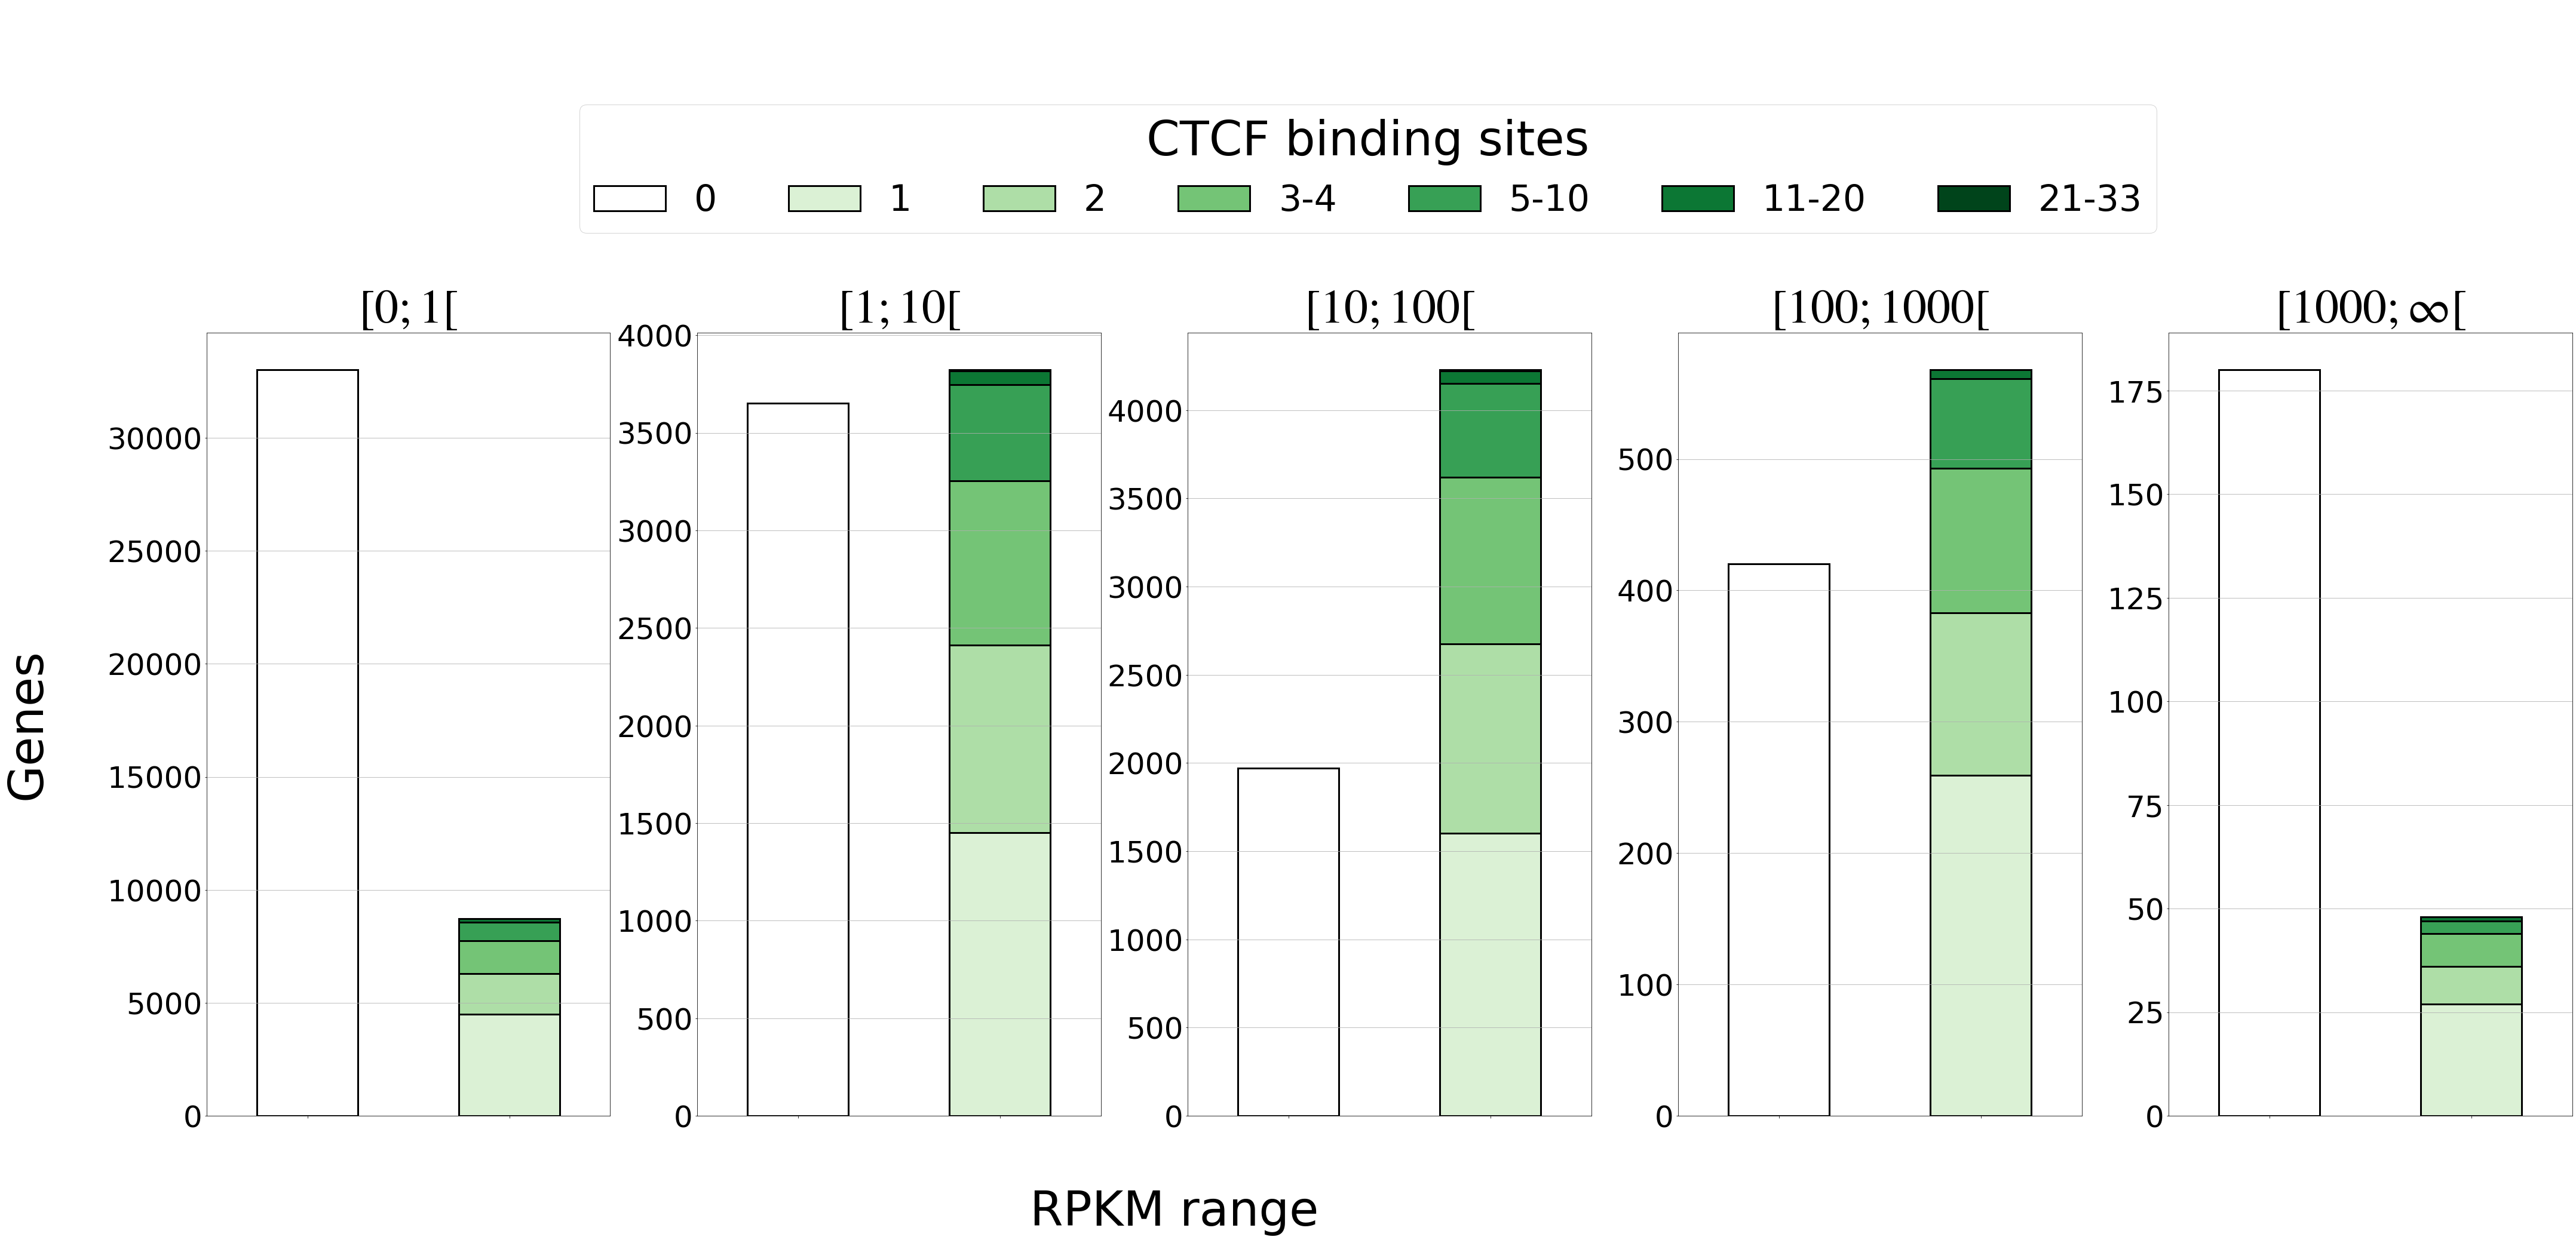

In [128]:
linewidth=3
legendfont = 42
titlefont = 80
labelfont = 40
tickfont = 50

fig, axes = plt.subplots(1, 5, figsize=(60, 20),tight_layout=True)
for i, g in enumerate(src.rpkm_class_to_name.values()):
    xg = groups.loc[[g], ['1', '2', '3-4', '5-10', '11-20', '21-33']]
    xg.loc['0', '0'] = groups.loc[g, '0']
    xg = xg.fillna(0)
    xg.loc[g, 'not_intersect'] = 0
    xg = xg.loc[['0', g], ['0', '1', '2', '3-4', '5-10', '11-20', '21-33']]
    xg.plot.bar(stacked=True, cmap=newcmp, ax=axes[i],edgecolor='black', linewidth=3)
    axes[i].legend().set_visible(False)
    axes[i].set_xticklabels([])
    axes[i].grid(axis="y")
    axes[i].tick_params(axis='y', labelsize=tickfont)
    axes[i].set_xlabel("")
    axes[i].set_title(g, fontsize=titlefont, fontweight="bold")
axes[0].set_ylabel("Genes\n", fontsize=80)
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=8, 
           bbox_to_anchor=(0.53,1.15), fontsize=60, 
           title='CTCF binding sites', title_fontsize=80)
fig.text(x=0.4, y=-0.1, s="RPKM range", fontsize=80)
plt.show()

In [131]:
groups = genexp_with_ctcfs.groupby('rpkm_class_name')[['0', 'C', 'CD', 'D', 'S']].sum()
groups = groups.rename(columns = {'0': 'None'})
groups.head()

None     C    CD     D     S
rpkm_class_name                                  
$[0; 1[$          33012.0  5369  4783  5019  5502
$[1000; \infty[$    180.0    22    21    27    26
$[100; 1000[$       420.0   359   344   376   313
$[10; 100[$        1972.0  2820  2794  2975  2906
$[1; 10[$          3651.0  2658  2489  2697  2569

In [133]:
cmap = plt.cm.get_cmap('Oranges', 7)
newcolors = cmap(np.linspace(0,1,7))
blue = np.array([1,1,1, 1])
newcolors[0, :] = blue
newcmp = ListedColormap(newcolors)

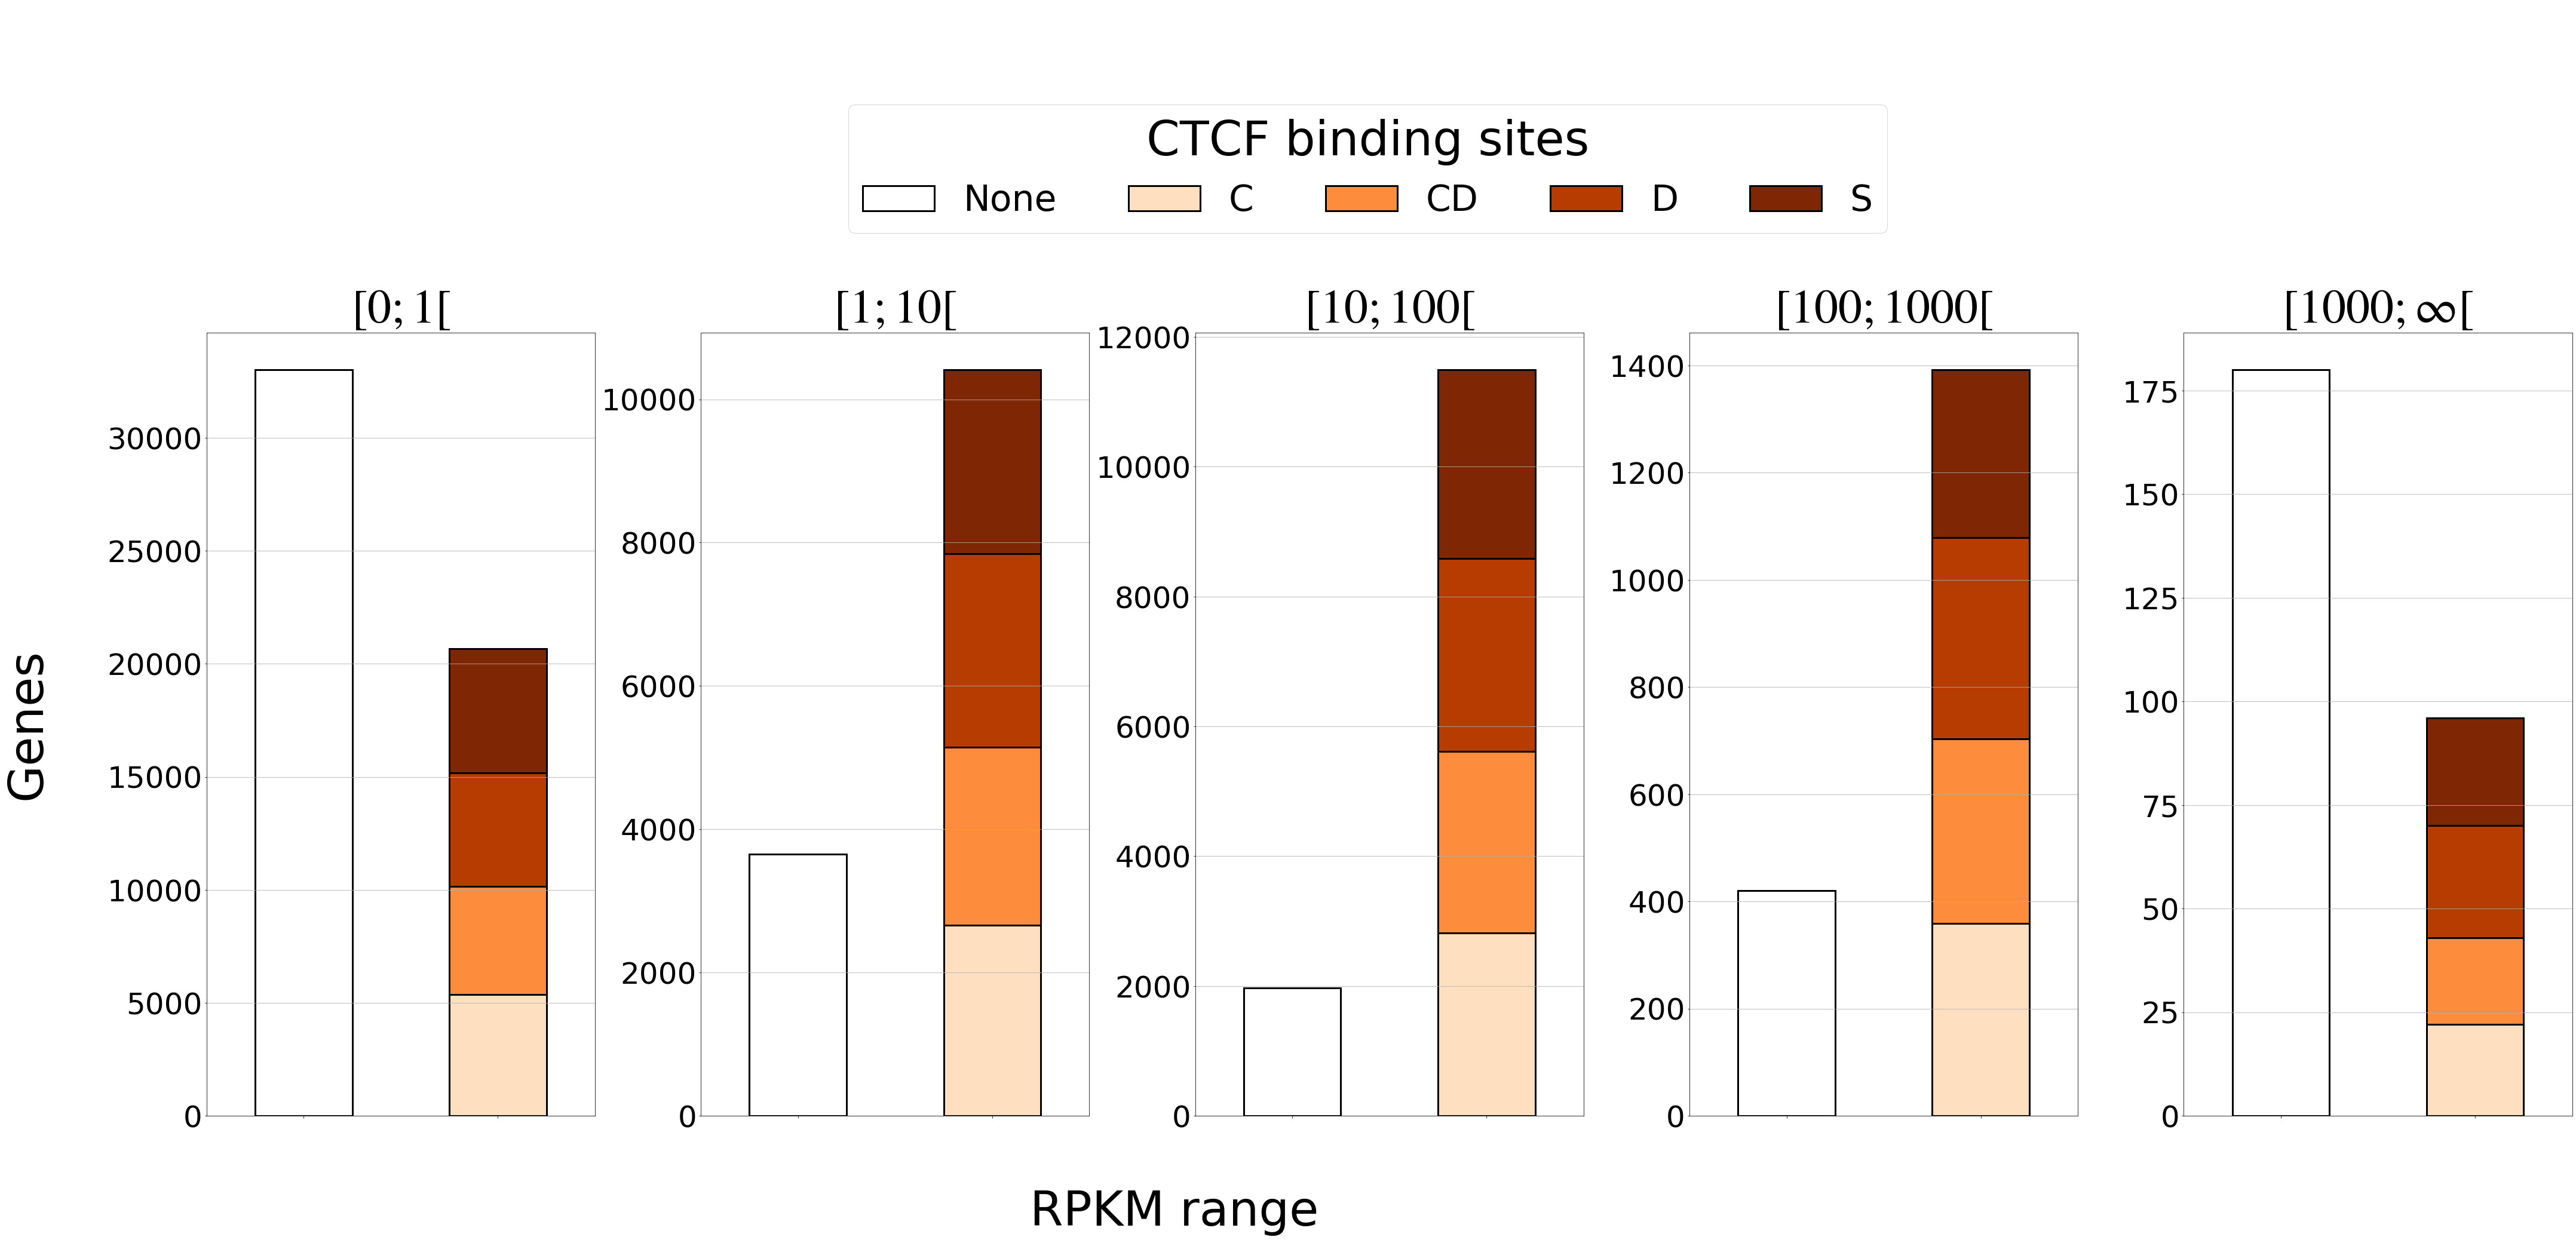

In [135]:
linewidth=3
legendfont = 42
titlefont = 80
labelfont = 40
tickfont = 50

fig, axes = plt.subplots(1, 5, figsize=(60, 20),tight_layout=True)
for i, g in enumerate(src.rpkm_class_to_name.values()):
    xg = groups.loc[[g], ['C', 'CD', 'D', 'S']]
    xg.loc['None', 'None'] = groups.loc[g, 'None']
    xg = xg.fillna(0)
    xg.loc[g, 'not_intersect'] = 0
    xg = xg.loc[['None', g], ['None', 'C', 'CD', 'D', 'S']]
    xg.plot.bar(stacked=True, cmap=newcmp, ax=axes[i],edgecolor='black', linewidth=3)
    axes[i].legend().set_visible(False)
    axes[i].set_xticklabels([])
    axes[i].grid(axis="y")
    axes[i].tick_params(axis='y', labelsize=tickfont)
    axes[i].set_xlabel("")
    axes[i].set_title(g, fontsize=titlefont, fontweight="bold")
axes[0].set_ylabel("Genes\n", fontsize=80)
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=8, 
           bbox_to_anchor=(0.53,1.15), fontsize=60, 
           title='CTCF binding sites', title_fontsize=80)
fig.text(x=0.4, y=-0.1, s="RPKM range", fontsize=80)
plt.show()

In [155]:
groups = genexp_with_ctcfs.groupby('rpkm_class_name')[['0', '1st quartile', '2nd quartile', '3rd quartile', '4th quartile']].sum()
groups = groups.rename(columns = {'0': 'None'})
groups.head()

None  1st quartile  2nd quartile  3rd quartile  \
rpkm_class_name                                                       
$[0; 1[$          33012.0          4856          5279          5273   
$[1000; \infty[$    180.0            36            17            26   
$[100; 1000[$       420.0           464           334           333   
$[10; 100[$        1972.0          3654          3028          2589   
$[1; 10[$          3651.0          2987          2697          2433   

                  4th quartile  
rpkm_class_name                 
$[0; 1[$                  5275  
$[1000; \infty[$            17  
$[100; 1000[$              261  
$[10; 100[$               2231  
$[1; 10[$                 2301

In [158]:
cmap = plt.cm.get_cmap('Purples', 7)
newcolors = cmap(np.linspace(0,1,7))
blue = np.array([1,1,1, 1])
newcolors[0, :] = blue
newcmp = ListedColormap(newcolors)

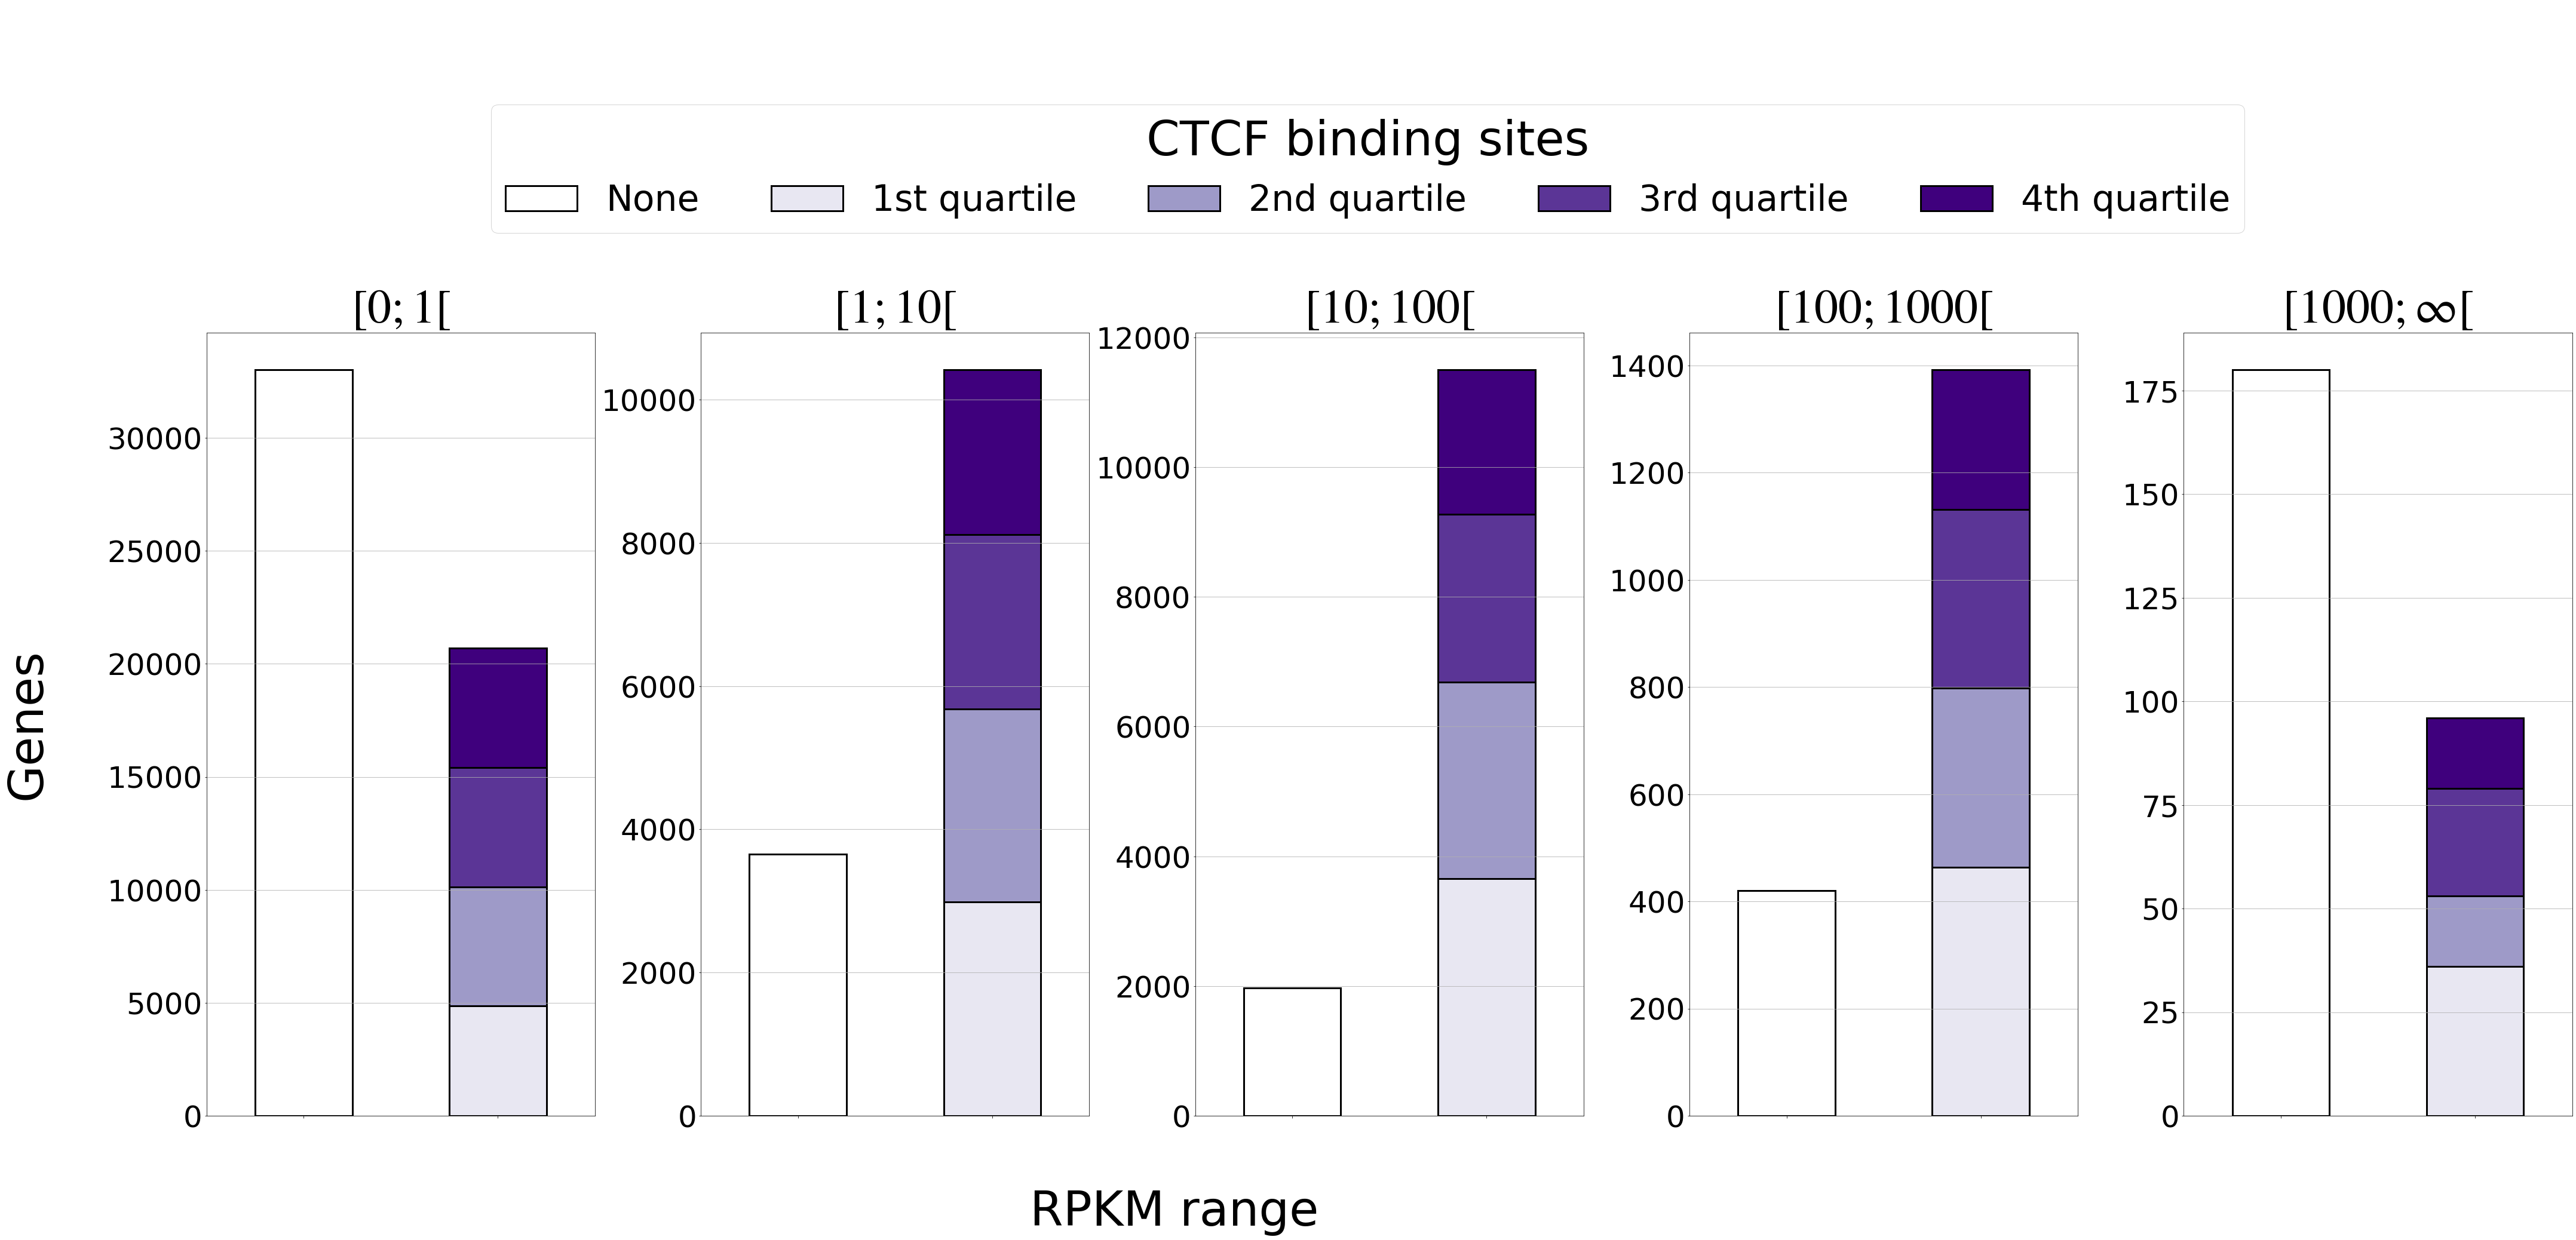

In [159]:
linewidth=3
legendfont = 42
titlefont = 80
labelfont = 40
tickfont = 50

fig, axes = plt.subplots(1, 5, figsize=(60, 20),tight_layout=True)
for i, g in enumerate(src.rpkm_class_to_name.values()):
    xg = groups.loc[[g], ['1st quartile', '2nd quartile', '3rd quartile', '4th quartile']]
    xg.loc['None', 'None'] = groups.loc[g, 'None']
    xg = xg.fillna(0)
    xg.loc[g, 'not_intersect'] = 0
    xg = xg.loc[['None', g], ['None', '1st quartile', '2nd quartile', '3rd quartile', '4th quartile']]
    xg.plot.bar(stacked=True, cmap=newcmp, ax=axes[i],edgecolor='black', linewidth=3)
    axes[i].legend().set_visible(False)
    axes[i].set_xticklabels([])
    axes[i].grid(axis="y")
    axes[i].tick_params(axis='y', labelsize=tickfont)
    axes[i].set_xlabel("")
    axes[i].set_title(g, fontsize=titlefont, fontweight="bold")
axes[0].set_ylabel("Genes\n", fontsize=80)
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=8, 
           bbox_to_anchor=(0.53,1.15), fontsize=60, 
           title='CTCF binding sites', title_fontsize=80)
fig.text(x=0.4, y=-0.1, s="RPKM range", fontsize=80)
plt.show()

### Positional enrichment of CTCF sites and classes on genes

In [78]:
n_windows = 100
extension = 0.1

tot_windows = n_windows + int(n_windows*extension)*2
gene_start_window = int(n_windows*extension)
gene_end_window = n_windows + int(n_windows*extension)

In [79]:
genexp_ext = BedTool.from_dataframe(genexp[src.coords + ['gene_uid']].sort_values(src.coords))\
                        .slop(l=extension, r=extension, pct=True, genome="hg19")\
                        .to_dataframe(names=src.coords + ['gene_uid'])
genexp_ext.head()

chr  start    end  gene_uid
0  chr1  11615  14666         0
1  chr1  12819  31350         1
2  chr1  29399  31264         2
3  chr1  34402  36233         3
4  chr1  52227  55182         4

In [80]:
windows = src.windowing_by_number(genexp_ext, tot_windows)

In [81]:
aggregations = {'ctcf_id': 'count', 
                'forward': 'sum', 
                'reverse': 'sum',
                'S': 'sum',
                'CD': 'sum', 
                'D': 'sum',
                'C': 'sum',
                'MotifScore': 'sum',
                'ChipSeqScore': 'sum'}

windows_with_ctcfs = src.coverage_by_window(windows, ctcfs, aggregations)
windows_with_ctcfs.head()

chr  start    end  gene_uid  w_num  ctcf_id  forward  reverse  S  CD  D  \
0  chr1  11615  11641         0      0        0        0        0  0   0  0   
1  chr1  11641  11667         0      1        0        0        0  0   0  0   
2  chr1  11667  11693         0      2        0        0        0  0   0  0   
3  chr1  11693  11719         0      3        0        0        0  0   0  0   
4  chr1  11719  11745         0      4        0        0        0  0   0  0   

   C  MotifScore  ChipSeqScore  
0  0         0.0           0.0  
1  0         0.0           0.0  
2  0         0.0           0.0  
3  0         0.0           0.0  
4  0         0.0           0.0

In [82]:
windows_with_ctcfs = windows_with_ctcfs.merge(genexp.drop(src.coords, axis=1), on='gene_uid')

In [83]:
aggregations_by_gene = {}
for c in src.progress(aggregations.keys()):
    cagg = windows_with_ctcfs.pivot_table(index='gene_uid', columns='w_num', values=c).sort_index(axis=1)
    aggregations_by_gene[c] = cagg 

In [160]:
# linewidth=3
# legendfont = 20
# labelfont = 20
# tickfont = 20

# fig, axes = plt.subplots(3,2,sharex='col', sharey='row', figsize=(20, 15))

# gene_set = genexp.loc[genexp.strand == '+', 'gene_uid'].tolist()

# axes[0,0].plot(aggregations_by_gene['ctcf_id'].loc[gene_set].mean(0), linewidth=linewidth, label='both', color='blue')
# axes[0,0].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
# axes[0,0].axvline(gene_start_window, color='black')
# axes[0,0].axvline(gene_end_window, color='black')
# axes[0,0].grid()
# axes[0,0].legend(loc='upper center', fontsize=legendfont)

# axes[1,0].plot(aggregations_by_gene['forward'].loc[gene_set].mean(0), linewidth=linewidth, label='Forward', color='red')
# axes[1,0].plot(aggregations_by_gene['reverse'].loc[gene_set].mean(0), linewidth=linewidth, label='Reverse', color='green')
# axes[1,0].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
# axes[1,0].axvline(gene_start_window, color='black')
# axes[1,0].axvline(gene_end_window, color='black')
# axes[1,0].grid()
# axes[1,0].legend(loc='upper center', fontsize=legendfont)

# axes[2,0].plot(aggregations_by_gene['S'].loc[gene_set].mean(0), linewidth=linewidth, label='Same', color='#FF6978')
# axes[2,0].plot(aggregations_by_gene['C'].loc[gene_set].mean(0), linewidth=linewidth, label='Convergent', color='#3B3561')
# axes[2,0].plot(aggregations_by_gene['D'].loc[gene_set].mean(0), linewidth=linewidth, label='Divergent', color='#768A77')
# axes[2,0].plot(aggregations_by_gene['CD'].loc[gene_set].mean(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
# axes[2,0].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
# axes[2,0].axvline(gene_start_window, color='black')
# axes[2,0].axvline(gene_end_window, color='black')
# axes[2,0].grid()
# axes[2,0].legend(loc='upper center', fontsize=legendfont)

# gene_set = genexp.loc[genexp.strand == '-', 'gene_uid'].tolist()

# axes[0,1].plot(aggregations_by_gene['ctcf_id'].loc[gene_set].mean(0), linewidth=linewidth, label='both', color='blue')
# axes[0,1].axvline(gene_start_window, color='black')
# axes[0,1].axvline(gene_end_window, color='black')
# axes[0,1].grid()
# axes[0,1].legend(loc='upper center', fontsize=legendfont)

# axes[1,1].plot(aggregations_by_gene['forward'].loc[gene_set].mean(0), linewidth=linewidth, label='Forward', color='red')
# axes[1,1].plot(aggregations_by_gene['reverse'].loc[gene_set].mean(0), linewidth=linewidth, label='Reverse', color='green')
# axes[1,1].axvline(gene_start_window, color='black')
# axes[1,1].axvline(gene_end_window, color='black')
# axes[1,1].grid()
# axes[1,1].legend(loc='upper center', fontsize=legendfont)

# axes[2,1].plot(aggregations_by_gene['S'].loc[gene_set].mean(0), linewidth=linewidth, label='Same', color='#FF6978')
# axes[2,1].plot(aggregations_by_gene['C'].loc[gene_set].mean(0), linewidth=linewidth, label='Convergent', color='#3B3561')
# axes[2,1].plot(aggregations_by_gene['D'].loc[gene_set].mean(0), linewidth=linewidth, label='Divergent', color='#768A77')
# axes[2,1].plot(aggregations_by_gene['CD'].loc[gene_set].mean(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
# axes[2,1].axvline(gene_start_window, color='black')
# axes[2,1].axvline(gene_end_window, color='black')
# axes[2,1].grid()
# axes[2,1].legend(loc='upper center', fontsize=legendfont)

# fig.text(0.3, 1.01, 'Positive Strand', fontsize=30, ha='center')
# fig.text(0.75, 1.01, 'Negative Strand', fontsize=30, ha='center')
# fig.savefig(figure_path / "avg_ctcf_sites_on_genes_by_window.pdf", bbox_inches='tight', transparent=True)
# plt.show()

In [161]:
promoter_size = 2000

In [162]:
tss = pd.read_csv(src.interim_data_path / 'hg19_ensembl_gene_tss.tsv', sep='\t')
tss = tss.merge(genexp[['gene', 'rpkm_class_name', 'gene_uid']], left_on='Gene name', right_on='gene')
tss['strand'] = tss.strand.map(lambda x: '+' if x > 0 else '-').astype(str)
tss = tss[['chr','tss_start', 'tss_start', 'strand', 'rpkm_class_name', 'gene_uid']]
tss.columns = src.coords + ['strand', 'rpkm_class_name', 'gene_uid']
tss.head()

chr   start     end strand rpkm_class_name  gene_uid
0  chr1  894636  894636      -     $[10; 100[$        65
1  chr1  895964  895964      +       $[1; 10[$        66
2  chr1  901877  901877      +        $[0; 1[$        67
3  chr1  901882  901882      +        $[0; 1[$        67
4  chr1  935491  935491      -        $[0; 1[$        69

In [163]:
window = 25000

consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / 'consensus_boundaries_w{}.tsv'.format(window), sep="\t")
cell_types = sorted(set(consensus_boundaries.cell_type.str.split(",").sum()))
consensus_boundaries.head()

chr    start      end                                       boundary_uid  \
0  chr1  1612500  1612500                                     Mon_0000_start   
1  chr1  1646875  1646875                                      nB_0000_start   
2  chr1  1842500  1847500            nB_0000_end,Ery_0000_start,Mon_0000_end   
3  chr1  2112500  2112500                      nB_0001_start,Mac0_0000_start   
4  chr1  2342500  2350000  nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...   

          cell_type  n_cell_types  n_boundaries  Ery  MK  Mac0  Mon  nB  nCD4  \
0               Mon             1             1    0   0     0    1   0     0   
1                nB             1             1    0   0     0    0   1     0   
2        nB,Mon,Ery             3             3    1   0     0    1   1     0   
3           nB,Mac0             2             2    0   0     1    0   1     0   
4  nB,Ery,Mac0,nCD8             4             5    1   0     1    0   2     0   

   nCD8  length  covered_genome  
0     0       1    3.223947e-10  
1     0       1    3.223947e-10  
2     0    5001    1.612296e-06  
3     0       1    3.223947e-10  
4     1    7501    2.418282e-06

In [164]:
tss_with_boundaries = BedTool.from_dataframe(tss).sort().map(BedTool.from_dataframe(consensus_boundaries).sort(), c=6, o='max', null=0)\
                        .to_dataframe(names = tss.columns.tolist() + ['n_cell_types'])

In [165]:
# # promoters = pd.DataFrame({
# #     'chr': genexp.chr,
# #     'start': genexp.apply(lambda x: max(0, x.start - promoter_size) if x.strand == '+' else x.end, axis=1),
# #     'end': genexp.apply(lambda x: x.start if x.strand == '+' else x.end + promoter_size, axis=1),
# #     'strand': genexp.strand,
# #     'rpkm_class_name': genexp.rpkm_class_name
# # })
# # promoters.head()

# tss = pd.DataFrame({
#     'chr': genexp.chr,
#     'pos': genexp.apply(lambda x: x.start if x.strand == '+' else x.end, axis=1),
#     'strand': genexp.strand,
#     'rpkm_class_name': genexp.rpkm_class_name,
#     'gene_uid': genexp.gene_uid
# })
# tss['start'] = tss.pos
# tss['end'] = tss.pos
# tss = tss[src.coords + ['strand', 'rpkm_class_name', 'gene_uid']]
# tss.head()

In [166]:
tss_grouped_by_genes = []
for gn, g in src.progress(tss.groupby('gene_uid')):
    tss_grouped_by_genes.append({
        'chr': g.chr.iloc[0],
        'start': g.start.min() if g.strand.iloc[0] == "+" else g.start.max(),
        'end': g.start.min() if g.strand.iloc[0] == "+" else g.start.max(),
        'strand': g.strand.iloc[0],
        'rpkm_class_name': g.rpkm_class_name.iloc[0],
        'gene_uid': gn
    })
tss_grouped_by_genes = pd.DataFrame.from_dict(tss_grouped_by_genes)
tss_grouped_by_genes = tss_grouped_by_genes.sort_values(src.coords)
tss_grouped_by_genes = tss_grouped_by_genes[src.coords + [c for c in tss_grouped_by_genes.columns if c not in src.coords]]
tss_grouped_by_genes.head()

chr   start     end  gene_uid rpkm_class_name strand
0  chr1  894636  894636        65     $[10; 100[$      -
1  chr1  895964  895964        66       $[1; 10[$      +
2  chr1  901877  901877        67        $[0; 1[$      +
3  chr1  935491  935491        69        $[0; 1[$      -
4  chr1  955500  955500        73       $[1; 10[$      +

In [167]:
extended = promoter_size
window_size = 10
tss = tss_grouped_by_genes
tss_extended = BedTool.from_dataframe(tss).slop(b=extended, genome='hg19').to_dataframe(names=tss.columns)
tss_extended = tss_extended[tss_extended.end - tss_extended.start == extended*2]
windows = src.windowing_by_size(tss_extended[src.coords + ['gene_uid']], window_size=window_size)

In [168]:
aggregations = {'ctcf_id': 'count', 
                'forward': 'sum', 
                'reverse': 'sum',
                'S': 'sum',
                'CD': 'sum', 
                'D': 'sum',
                'C': 'sum',
                'MotifScore': 'sum',
                'ChipSeqScore': 'sum'}

for o in ['>', '<']:
    for c in ['S', 'CD', 'D', 'C']:
        aggregations[o + c] = 'sum'
print(aggregations)
windows_with_ctcfs = src.coverage_by_window(windows, ctcfs, aggregations)
windows_with_ctcfs.head()

{'ctcf_id': 'count', 'forward': 'sum', 'reverse': 'sum', 'S': 'sum', 'CD': 'sum', 'D': 'sum', 'C': 'sum', 'MotifScore': 'sum', 'ChipSeqScore': 'sum', '>S': 'sum', '>CD': 'sum', '>D': 'sum', '>C': 'sum', '<S': 'sum', '<CD': 'sum', '<D': 'sum', '<C': 'sum'}


chr   start     end  gene_uid  w_num  ctcf_id  forward  reverse  S  CD  \
0  chr1  892636  892646        65      0        0        0        0  0   0   
1  chr1  892646  892656        65      1        0        0        0  0   0   
2  chr1  892656  892666        65      2        0        0        0  0   0   
3  chr1  892666  892676        65      3        0        0        0  0   0   
4  chr1  892676  892686        65      4        0        0        0  0   0   

   ...  MotifScore  ChipSeqScore  >S  >CD  >D  >C  <S  <CD  <D  <C  
0  ...         0.0           0.0   0    0   0   0   0    0   0   0  
1  ...         0.0           0.0   0    0   0   0   0    0   0   0  
2  ...         0.0           0.0   0    0   0   0   0    0   0   0  
3  ...         0.0           0.0   0    0   0   0   0    0   0   0  
4  ...         0.0           0.0   0    0   0   0   0    0   0   0  

[5 rows x 22 columns]

In [169]:
windows_with_ctcfs = windows_with_ctcfs.merge(genexp.drop(src.coords, axis=1), on='gene_uid')

In [170]:
aggregations_by_gene = {}
for c in src.progress(aggregations.keys()):
    cagg = windows_with_ctcfs.pivot_table(index='gene_uid', columns='w_num', values=c).sort_index(axis=1)
    aggregations_by_gene[c] = cagg 

In [209]:
def mirror(m):
    r = np.zeros_like(m)
    for i in range(int(m.shape[1])):
        r[:,i] = m[:,-(i + 1)]
    return r

In [195]:
aggregations_by_gene_merged = {}
for c in src.progress(aggregations_by_gene.keys()):
    pos_set = tss.loc[tss.strand == '+', 'gene_uid'].tolist()
    neg_set = tss.loc[tss.strand == '-', 'gene_uid'].tolist()
    mirrored_neg = pd.DataFrame(data=mirror(aggregations_by_gene[c].loc[neg_set].values), index=neg_set)
    cagg = pd.concat((aggregations_by_gene[c].loc[pos_set], mirrored_neg), axis=0)
    aggregations_by_gene_merged[c] = cagg

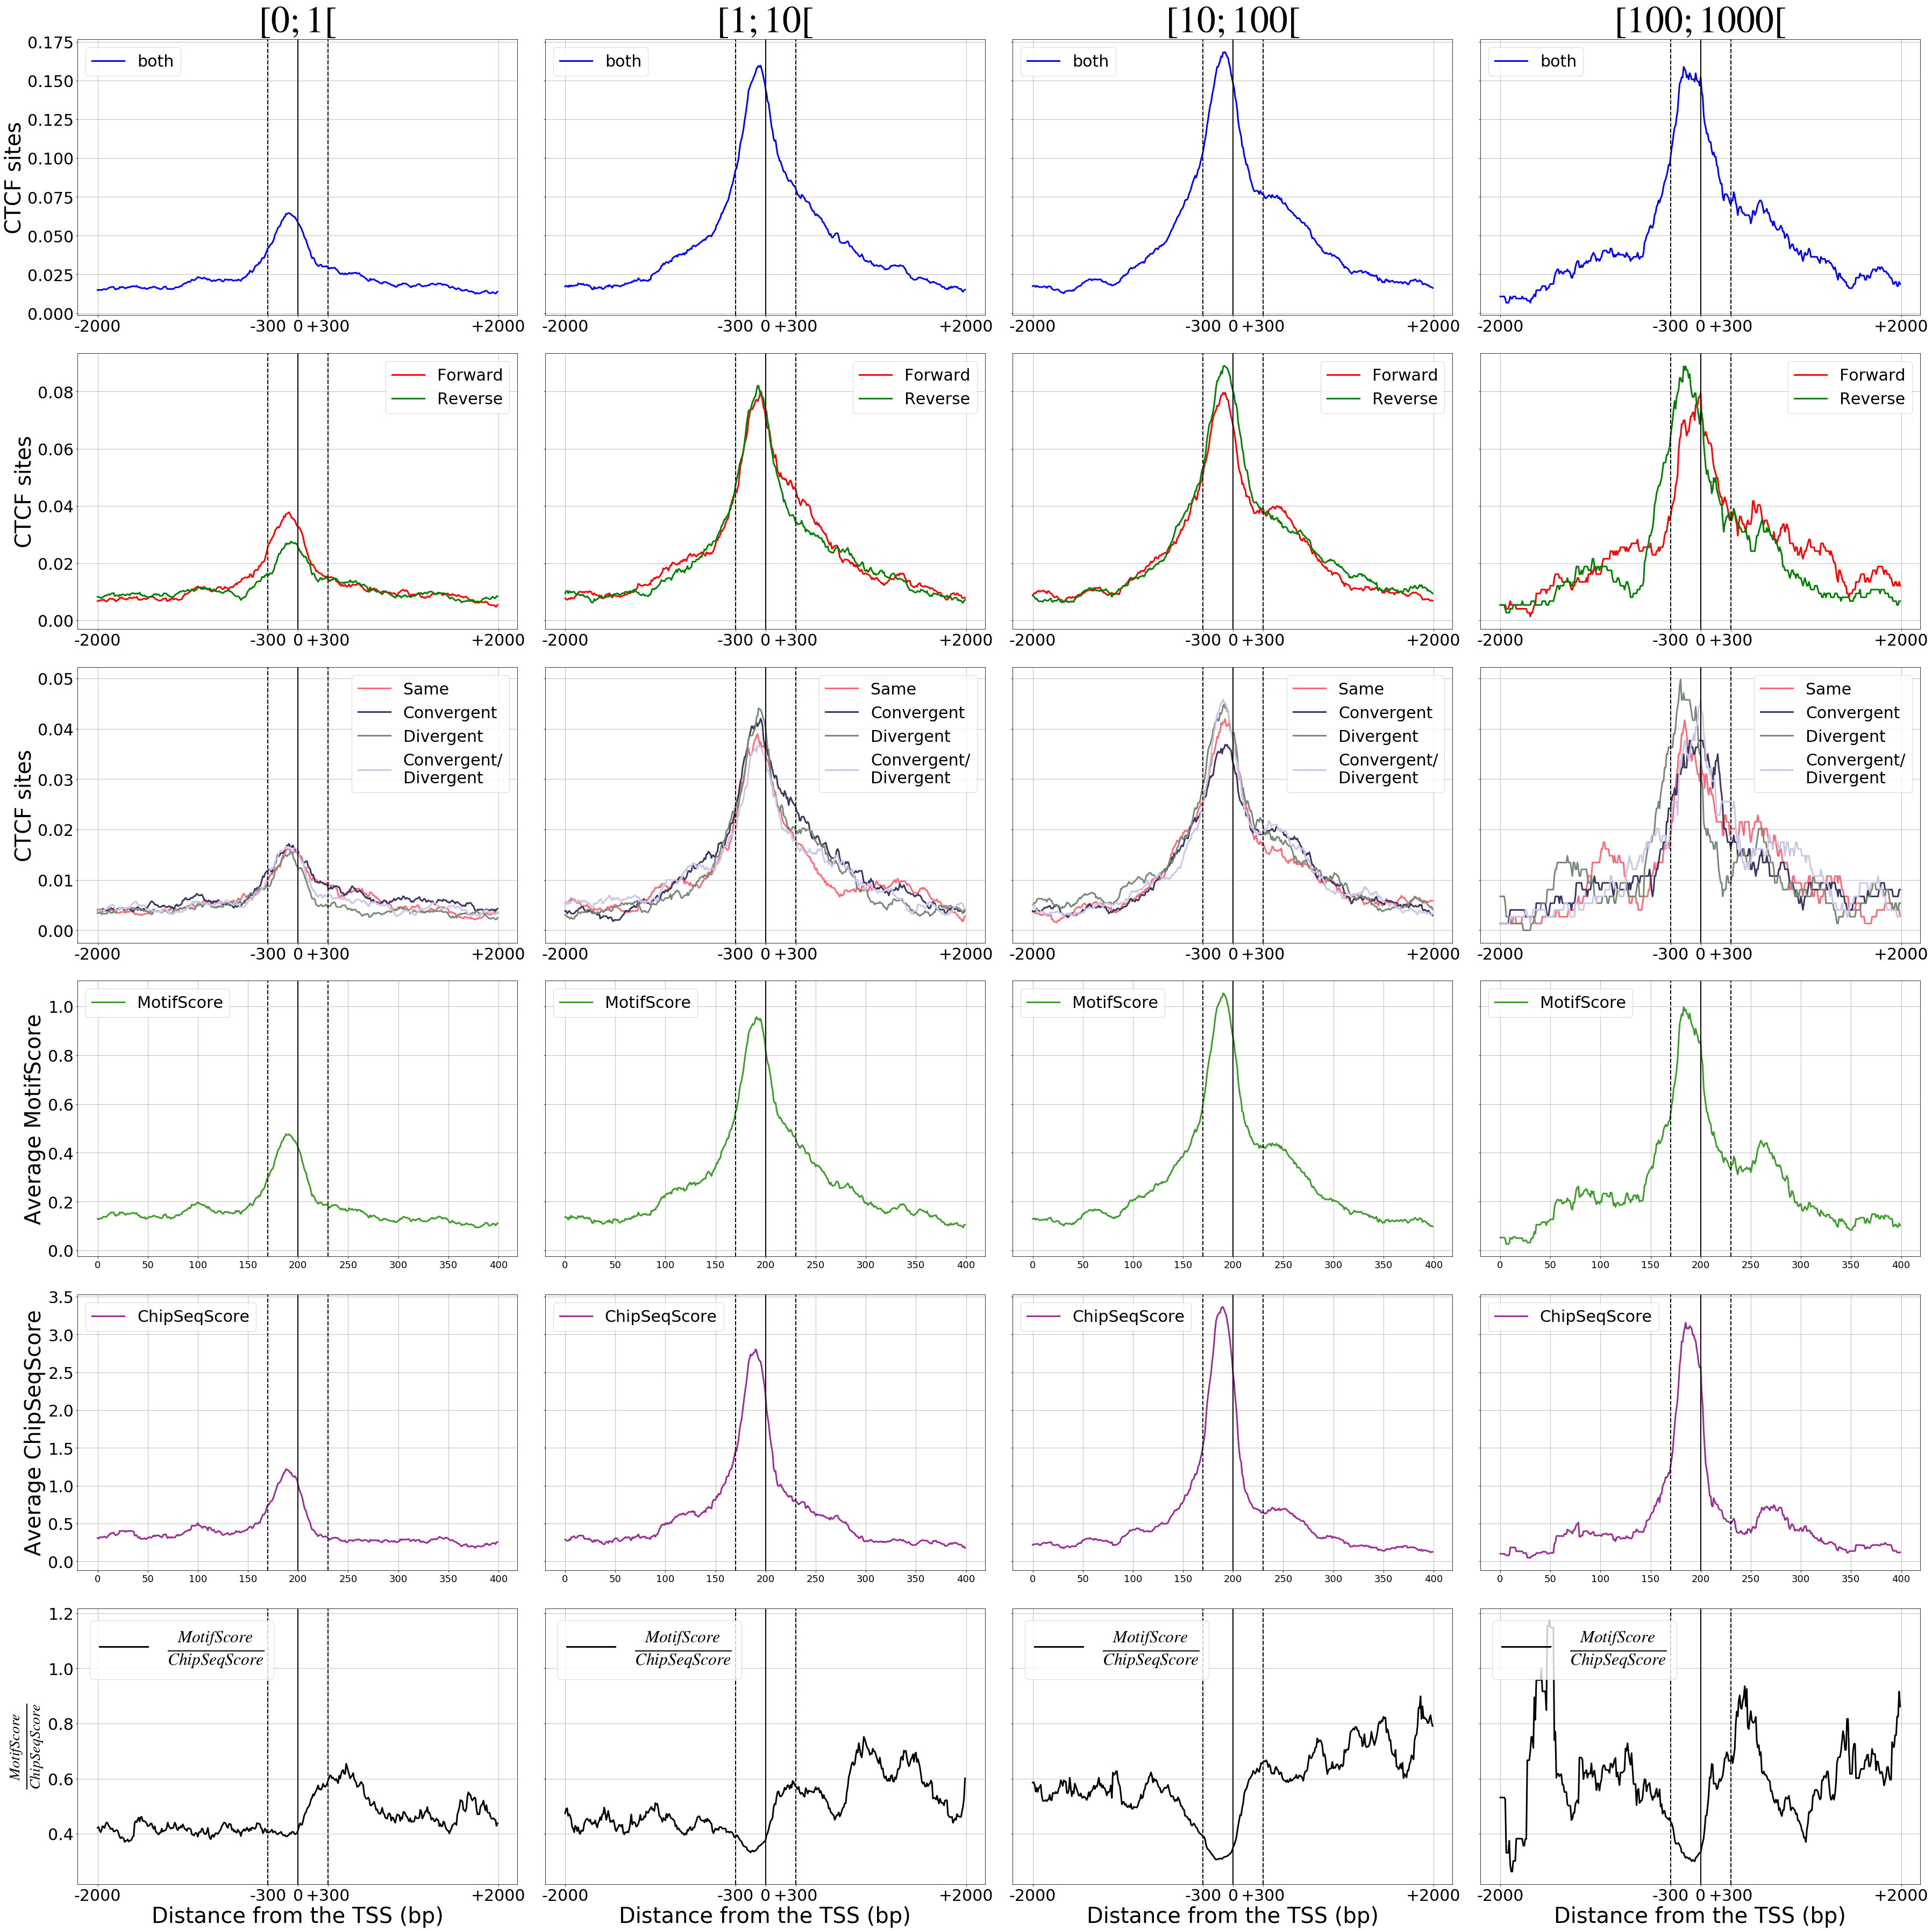

In [242]:
intermediate_lines = 300
score = lambda i: ("+" if i > 0 else "") + str(i)
lines = [(promoter_size - intermediate_lines)/window_size, promoter_size/window_size, (promoter_size + intermediate_lines)/window_size]
linestyles = ['--', '-', '--']
linewidth=3
legendfont=30
labelfont=40
tickfont=30

fig, axes = plt.subplots(6,4, tight_layout=True, figsize=(50, 50), sharey='row')
for i, g in enumerate(list(src.rpkm_class_to_name.values())[:-1]):
    
    selected_genes = tss.loc[tss.rpkm_class_name == g, 'gene_uid'].tolist()
    
    axes[0, i].set_title(g, fontsize=70)
    axes[0, i].plot(aggregations_by_gene_merged['ctcf_id'].loc[selected_genes].mean(0), linewidth=linewidth, label='both', color='blue')
    axes[0, i].axvline(promoter_size/window_size, color='black')
    axes[0, i].grid()
    axes[0, i].legend(loc='upper left', fontsize=legendfont)
    for l,ls in zip(lines, linestyles):
        axes[0, i].axvline(l, color='black', linestyle=ls)
    xticks = [0] + lines + [2*promoter_size/window_size]
    xticklabels = ['-{}'.format(promoter_size)] + ["{}".format(score(int(l*window_size - promoter_size))) for l in lines ] + ['+{}'.format(promoter_size)]
    axes[0, i].set_xticks(xticks)
    axes[0, i].set_xticklabels(xticklabels, fontsize=tickfont)
    axes[0, i].legend(loc='upper left', fontsize=legendfont)
    axes[0, i].tick_params(axis='y', labelsize =tickfont)
    if i == 0:
        axes[0, i].set_ylabel("CTCF sites", fontsize=labelfont)
    
    axes[1, i].plot(aggregations_by_gene_merged['forward'].loc[selected_genes].mean(0), linewidth=linewidth, label='Forward', color='red')
    axes[1, i].plot(aggregations_by_gene_merged['reverse'].loc[selected_genes].mean(0), linewidth=linewidth, label='Reverse', color='green')
    axes[1, i].axvline(promoter_size/window_size, color='black')
    axes[1, i].grid()
    axes[1, i].legend(loc='upper left', fontsize=legendfont)
    for l,ls in zip(lines, linestyles):
        axes[1, i].axvline(l, color='black', linestyle=ls)
    xticks = [0] + lines + [2*promoter_size/window_size]
    xticklabels = ['-{}'.format(promoter_size)] + ["{}".format(score(int(l*window_size - promoter_size))) for l in lines ] + ['+{}'.format(promoter_size)]
    axes[1, i].set_xticks(xticks)
    axes[1, i].set_xticklabels(xticklabels, fontsize=tickfont)
    axes[1, i].legend(loc='upper right', fontsize=legendfont)
    axes[1, i].tick_params(axis='y', labelsize =tickfont)
    if i == 0:
        axes[1, i].set_ylabel("CTCF sites", fontsize=labelfont)

    
    axes[2, i].plot(aggregations_by_gene_merged['S'].loc[selected_genes].mean(0), linewidth=linewidth, label='Same', color='#FF6978')
    axes[2, i].plot(aggregations_by_gene_merged['C'].loc[selected_genes].mean(0), linewidth=linewidth, label='Convergent', color='#3B3561')
    axes[2, i].plot(aggregations_by_gene_merged['D'].loc[selected_genes].mean(0), linewidth=linewidth, label='Divergent', color='#768A77')
    axes[2, i].plot(aggregations_by_gene_merged['CD'].loc[selected_genes].mean(0), linewidth=linewidth, label='Convergent/\nDivergent', color='#CBC5EA')    
    axes[2, i].axvline(promoter_size/window_size, color='black')
    axes[2, i].grid()
    axes[2, i].legend(loc='upper left', fontsize=legendfont)
    for l,ls in zip(lines, linestyles):
        axes[2, i].axvline(l, color='black', linestyle=ls)
    xticks = [0] + lines + [2*promoter_size/window_size]
    xticklabels = ['-{}'.format(promoter_size)] + ["{}".format(score(int(l*window_size - promoter_size))) for l in lines ] + ['+{}'.format(promoter_size)]
    axes[2, i].set_xticks(xticks)
    axes[2, i].set_xticklabels(xticklabels, fontsize=tickfont)
    axes[2, i].legend(loc='upper right', fontsize=legendfont)
    axes[2, i].tick_params(axis='y', labelsize =tickfont)
    if i == 0:
        axes[2, i].set_ylabel("CTCF sites", fontsize=labelfont)

    
    axes[3, i].plot(aggregations_by_gene_merged['MotifScore'].loc[selected_genes].mean(0), linewidth=linewidth, label='MotifScore', color='#3E9C2B')
    if i == 0:
        axes[3, i].set_ylabel("Average MotifScore", fontsize=labelfont)
    for l,ls in zip(lines, linestyles):
        axes[3, i].axvline(l, color='black', linestyle=ls)
    axes[3, i].grid()
    axes[3, i].legend(loc='upper left', fontsize=legendfont)
    axes[3, i].tick_params(axis='y', labelsize =tickfont)


    axes[4, i].plot(aggregations_by_gene_merged['ChipSeqScore'].loc[selected_genes].mean(0), linewidth=linewidth, label='ChipSeqScore', color='#9C2B95')
    if i == 0:
        axes[4, i].set_ylabel("Average ChipSeqScore", fontsize=labelfont)
    for l,ls in zip(lines, linestyles):
        axes[4, i].axvline(l, color='black', linestyle=ls)
    axes[4, i].grid()
    axes[4, i].legend(loc='upper left', fontsize=legendfont)
    axes[4, i].tick_params(axis='y', labelsize =tickfont)


    ratio = aggregations_by_gene_merged['MotifScore'].loc[selected_genes].mean(0) / aggregations_by_gene_merged['ChipSeqScore'].loc[selected_genes].mean(0)

    axes[5, i].plot(ratio, linewidth=linewidth, label=r"$\frac{MotifScore}{ChipSeqScore}$", color='black')
    if i == 0:
        axes[5, i].set_ylabel(r"$\frac{MotifScore}{ChipSeqScore}$", fontsize=labelfont)
    for l,ls in zip(lines, linestyles):
        axes[5, i].axvline(l, color='black', linestyle=ls)
    axes[5, i].grid()
    axes[5, i].legend(loc='upper left', fontsize=legendfont*1.5)
    axes[5, i].tick_params(axis='y', labelsize =tickfont)

    xticks = [0] + lines + [2*promoter_size/window_size]
    xticklabels = ['-{}'.format(promoter_size)] + ["{}".format(score(int(l*window_size - promoter_size))) for l in lines ] + ['+{}'.format(promoter_size)]
    axes[5, i].set_xticks(xticks)
    axes[5, i].set_xticklabels(xticklabels, fontsize=tickfont)
    axes[5, i].set_xlabel("Distance from the TSS (bp)", fontsize=labelfont)
    
    
        
plt.show()

In [186]:
def pattern_stats(aggregations_by_gene, selected_genes, 
                 lines = [(promoter_size - intermediate_lines)/window_size, promoter_size/window_size, (promoter_size + intermediate_lines)/window_size],
                 linestyles = ['--', '-', '--'],
                 linewidth=3, legendfont=20, labelfont=20, tickfont=20):
    
    def pattern_stats_strand(aggregations_by_gene, gene_set, axes, s=0):
        axes[0,s].plot(aggregations_by_gene['ctcf_id'].loc[gene_set].sum(0), linewidth=linewidth, label='both', color='blue')
        axes[0,s].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
        axes[0,s].axvline(promoter_size/window_size, color='black')
        axes[0,s].axvline(promoter_size/window_size, color='black')
        # axes[0,0].axvline(gene_end_window, color='black')
        axes[0,s].grid()
        axes[0,s].legend(loc='upper left', fontsize=legendfont)
        
        axes[1,s].plot(aggregations_by_gene['>S'].loc[gene_set].sum(0), linewidth=linewidth, label='Same', color='#FF6978')
        axes[1,s].plot(aggregations_by_gene['>C'].loc[gene_set].sum(0), linewidth=linewidth, label='Convergent', color='#3B3561')
        axes[1,s].plot(aggregations_by_gene['>D'].loc[gene_set].sum(0), linewidth=linewidth, label='Divergent', color='#768A77')
        axes[1,s].plot(aggregations_by_gene['>CD'].loc[gene_set].sum(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
        axes[1,s].axvline(promoter_size/window_size, color='black')
        # axes[2,1].axvline(gene_end_window, color='black')
        axes[1,s].grid()
        axes[1,s].legend(loc='upper left', fontsize=legendfont)
        axes[1,s].set_title("Forward")
        
        axes[2,s].plot(aggregations_by_gene['<S'].loc[gene_set].sum(0), linewidth=linewidth, label='Same', color='#FF6978')
        axes[2,s].plot(aggregations_by_gene['<C'].loc[gene_set].sum(0), linewidth=linewidth, label='Convergent', color='#3B3561')
        axes[2,s].plot(aggregations_by_gene['<D'].loc[gene_set].sum(0), linewidth=linewidth, label='Divergent', color='#768A77')
        axes[2,s].plot(aggregations_by_gene['<CD'].loc[gene_set].sum(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
        axes[2,s].axvline(promoter_size/window_size, color='black')
        # axes[2,1].axvline(gene_end_window, color='black')
        axes[2,s].grid()
        axes[2,s].legend(loc='upper left', fontsize=legendfont)
        axes[2,s].set_title("Reverse")
        
        xticks = [0] + lines + [2*promoter_size/window_size]
        xticklabels = ['-{}'.format(promoter_size)] + ["{}".format(score(int(l*window_size - promoter_size))) for l in lines ] + ['+{}'.format(promoter_size)]
        axes[2,s].set_xticks(xticks)
        axes[2,s].set_xticklabels(xticklabels, fontsize=tickfont)
        axes[2,s].set_xlabel("Distance from the TSS (bp)", fontsize=labelfont)
        
    
    fig, axes = plt.subplots(3,2,sharex='col', sharey='row', figsize=(20, 15))
    gene_set = genexp.loc[genexp.strand == '+', 'gene_uid'].tolist()
    gene_set = set(gene_set).intersection(set(selected_genes))
    pattern_stats_strand(aggregations_by_gene, gene_set, s=0, axes=axes)
    gene_set = genexp.loc[genexp.strand == '-', 'gene_uid'].tolist()
    gene_set = set(gene_set).intersection(set(selected_genes))
    pattern_stats_strand(aggregations_by_gene, gene_set, s=1, axes=axes)
    
    fig.text(0.3, 1.01, 'Positive Strand', fontsize=30, ha='center')
    fig.text(0.75, 1.01, 'Negative Strand', fontsize=30, ha='center')
    
    return fig, axes

In [179]:


def pattern_stats(aggregations_by_gene, selected_genes, 
                 lines = [(promoter_size - intermediate_lines)/window_size, promoter_size/window_size, (promoter_size + intermediate_lines)/window_size],
                 linestyles = ['--', '-', '--'],
                 linewidth=3, legendfont=20, labelfont=20, tickfont=20):
    
    def pattern_stats_strand(aggregations_by_gene, gene_set, axes, s=0):
        axes[0,s].plot(aggregations_by_gene['ctcf_id'].loc[gene_set].sum(0), linewidth=linewidth, label='both', color='blue')
        axes[0,s].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
        axes[0,s].axvline(promoter_size/window_size, color='black')
        axes[0,s].axvline(promoter_size/window_size, color='black')
        # axes[0,0].axvline(gene_end_window, color='black')
        axes[0,s].grid()
        axes[0,s].legend(loc='upper left', fontsize=legendfont)
        
        axes[1,s].plot(aggregations_by_gene['>S'].loc[gene_set].sum(0), linewidth=linewidth, label='Same', color='#FF6978')
        axes[1,s].plot(aggregations_by_gene['>C'].loc[gene_set].sum(0), linewidth=linewidth, label='Convergent', color='#3B3561')
        axes[1,s].plot(aggregations_by_gene['>D'].loc[gene_set].sum(0), linewidth=linewidth, label='Divergent', color='#768A77')
        axes[1,s].plot(aggregations_by_gene['>CD'].loc[gene_set].sum(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
        axes[1,s].axvline(promoter_size/window_size, color='black')
        # axes[2,1].axvline(gene_end_window, color='black')
        axes[1,s].grid()
        axes[1,s].legend(loc='upper left', fontsize=legendfont)
        axes[1,s].set_title("Forward")
        
        axes[2,s].plot(aggregations_by_gene['<S'].loc[gene_set].sum(0), linewidth=linewidth, label='Same', color='#FF6978')
        axes[2,s].plot(aggregations_by_gene['<C'].loc[gene_set].sum(0), linewidth=linewidth, label='Convergent', color='#3B3561')
        axes[2,s].plot(aggregations_by_gene['<D'].loc[gene_set].sum(0), linewidth=linewidth, label='Divergent', color='#768A77')
        axes[2,s].plot(aggregations_by_gene['<CD'].loc[gene_set].sum(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
        axes[2,s].axvline(promoter_size/window_size, color='black')
        # axes[2,1].axvline(gene_end_window, color='black')
        axes[2,s].grid()
        axes[2,s].legend(loc='upper left', fontsize=legendfont)
        axes[2,s].set_title("Reverse")
        
        xticks = [0] + lines + [2*promoter_size/window_size]
        xticklabels = ['-{}'.format(promoter_size)] + ["{}".format(score(int(l*window_size - promoter_size))) for l in lines ] + ['+{}'.format(promoter_size)]
        axes[2,s].set_xticks(xticks)
        axes[2,s].set_xticklabels(xticklabels, fontsize=tickfont)
        axes[2,s].set_xlabel("Distance from the TSS (bp)", fontsize=labelfont)
        
    
    fig, axes = plt.subplots(3,2,sharex='col', sharey='row', figsize=(20, 15))
    gene_set = genexp.loc[genexp.strand == '+', 'gene_uid'].tolist()
    gene_set = set(gene_set).intersection(set(selected_genes))
    pattern_stats_strand(aggregations_by_gene, gene_set, s=0, axes=axes)
    gene_set = genexp.loc[genexp.strand == '-', 'gene_uid'].tolist()
    gene_set = set(gene_set).intersection(set(selected_genes))
    pattern_stats_strand(aggregations_by_gene, gene_set, s=1, axes=axes)
    
    fig.text(0.3, 1.01, 'Positive Strand', fontsize=30, ha='center')
    fig.text(0.75, 1.01, 'Negative Strand', fontsize=30, ha='center')
    
    return fig, axes

def signal_stats(aggregations_by_gene, selected_genes, 
                 lines = [(promoter_size - intermediate_lines)/window_size, promoter_size/window_size, (promoter_size + intermediate_lines)/window_size],
                 linestyles = ['--', '-', '--'],
                 linewidth=3, legendfont=20, labelfont=20, tickfont=20):
    
    def signal_stats_strand(aggregations_by_gene, gene_set, axes, s=0):
        
        axes[0,s].plot(aggregations_by_gene['MotifScore'].loc[gene_set].mean(0), linewidth=linewidth, label='MotifScore', color='#3E9C2B')
        axes[0,s].set_ylabel("Average MotifScore", fontsize=labelfont)
        for l,ls in zip(lines, linestyles):
            axes[0,s].axvline(l, color='black', linestyle=ls)
        axes[0,s].grid()
        axes[0,s].legend(loc='upper left', fontsize=legendfont)
        
        axes[1,s].plot(aggregations_by_gene['ChipSeqScore'].loc[gene_set].mean(0), linewidth=linewidth, label='ChipSeqScore', color='#9C2B95')
        axes[1,s].set_ylabel("Average ChipSeqScore", fontsize=labelfont)
        for l,ls in zip(lines, linestyles):
            axes[1,s].axvline(l, color='black', linestyle=ls)
        axes[1,s].grid()
        axes[1,s].legend(loc='upper left', fontsize=legendfont)
        
        ratio = aggregations_by_gene['MotifScore'].loc[gene_set].mean(0) / aggregations_by_gene['ChipSeqScore'].loc[gene_set].mean(0)
        
        axes[2,s].plot(ratio, linewidth=linewidth, label=r"$\frac{MotifScore}{ChipSeqScore}$", color='black')
        axes[2,s].set_ylabel(r"$\frac{MotifScore}{ChipSeqScore}$", fontsize=labelfont)
        for l,ls in zip(lines, linestyles):
            axes[2,s].axvline(l, color='black', linestyle=ls)
        axes[2,s].grid()
        axes[2,s].legend(loc='upper left', fontsize=legendfont)
        
        xticks = [0] + lines + [2*promoter_size/window_size]
        xticklabels = ['-{}'.format(promoter_size)] + ["{}".format(score(int(l*window_size - promoter_size))) for l in lines ] + ['+{}'.format(promoter_size)]
        axes[2,s].set_xticks(xticks)
        axes[2,s].set_xticklabels(xticklabels, fontsize=tickfont)
        axes[2,s].set_xlabel("Distance from the TSS (bp)", fontsize=labelfont)
        
    
    fig, axes = plt.subplots(3,2,sharex='col', sharey='row', figsize=(20, 15))
    gene_set = genexp.loc[genexp.strand == '+', 'gene_uid'].tolist()
    gene_set = set(gene_set).intersection(set(selected_genes))
    signal_stats_strand(aggregations_by_gene, gene_set, s=0, axes=axes)
    gene_set = genexp.loc[genexp.strand == '-', 'gene_uid'].tolist()
    gene_set = set(gene_set).intersection(set(selected_genes))
    signal_stats_strand(aggregations_by_gene, gene_set, s=1, axes=axes)
    
    fig.text(0.3, 1.01, 'Positive Strand', fontsize=30, ha='center')
    fig.text(0.75, 1.01, 'Negative Strand', fontsize=30, ha='center')
    
    return fig, axes


def stats(aggregations_by_gene, selected_genes, linewidth=3, legendfont=20, labelfont=20, tickfont=20):
    fig, axes = plt.subplots(4,2,sharex='col', sharey='row', figsize=(20, 20))
    gene_set = genexp.loc[genexp.strand == '+', 'gene_uid'].tolist()
    gene_set = set(gene_set).intersection(set(selected_genes))
    
    axes[0,0].plot(aggregations_by_gene['ctcf_id'].loc[gene_set].mean(0), linewidth=linewidth, label='both', color='blue')
    axes[0,0].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
    axes[0,0].axvline(promoter_size/window_size, color='black')
    axes[0,0].axvline(promoter_size/window_size, color='black')
    # axes[0,0].axvline(gene_end_window, color='black')
    axes[0,0].grid()
    axes[0,0].legend(loc='upper left', fontsize=legendfont)

    axes[1,0].plot(aggregations_by_gene['forward'].loc[gene_set].mean(0), linewidth=linewidth, label='Forward', color='red')
    axes[1,0].plot(aggregations_by_gene['reverse'].loc[gene_set].mean(0), linewidth=linewidth, label='Reverse', color='green')
    axes[1,0].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
    axes[1,0].axvline(promoter_size/window_size, color='black')
    # axes[1,0].axvline(gene_end_window, color='black')
    axes[1,0].grid()
    axes[1,0].legend(loc='upper left', fontsize=legendfont)

    axes[2,0].plot(aggregations_by_gene['S'].loc[gene_set].mean(0), linewidth=linewidth, label='Same', color='#FF6978')
    axes[2,0].plot(aggregations_by_gene['C'].loc[gene_set].mean(0), linewidth=linewidth, label='Convergent', color='#3B3561')
    axes[2,0].plot(aggregations_by_gene['D'].loc[gene_set].mean(0), linewidth=linewidth, label='Divergent', color='#768A77')
    axes[2,0].plot(aggregations_by_gene['CD'].loc[gene_set].mean(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
    axes[2,0].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
    axes[2,0].axvline(promoter_size/window_size, color='black')
    axes[2,0].grid()
    axes[2,0].legend(loc='upper left', fontsize=legendfont)
    
    
    
    axes301 = axes[3,0].twinx()
    axes301.plot(aggregations_by_gene['ChipSeqScore'].loc[gene_set].mean(0), linewidth=linewidth, label='ChipSeqScore', color='#9C2B95')
    axes301.set_ylabel("Average ChipSeqScore", fontsize=labelfont, color="#9C2B95")
    axes301.tick_params(axis='y', labelcolor="#9C2B95")
    axes[3,0].set_xticks([0, promoter_size/window_size, 2*promoter_size/window_size])
    axes[3,0].set_xticklabels(['-{}bp'.format(promoter_size), 'TSS', '+{}bp'.format(promoter_size)], fontsize=tickfont)

    gene_set = genexp.loc[genexp.strand == '-', 'gene_uid'].tolist()
    gene_set = set(gene_set).intersection(set(selected_genes))

    axes[0,1].plot(aggregations_by_gene['ctcf_id'].loc[gene_set].mean(0), linewidth=linewidth, label='both', color='blue')
    axes[0,1].axvline(promoter_size/window_size, color='black')
    # axes[0,1].axvline(gene_end_window, color='black')
    axes[0,1].grid()
    axes[0,1].legend(loc='upper left', fontsize=legendfont)

    axes[1,1].plot(aggregations_by_gene['forward'].loc[gene_set].mean(0), linewidth=linewidth, label='Forward', color='red')
    axes[1,1].plot(aggregations_by_gene['reverse'].loc[gene_set].mean(0), linewidth=linewidth, label='Reverse', color='green')
    axes[1,1].axvline(promoter_size/window_size, color='black')
    # axes[1,1].axvline(gene_end_window, color='black')
    axes[1,1].grid()
    axes[1,1].legend(loc='upper left', fontsize=legendfont)

    axes[2,1].plot(aggregations_by_gene['S'].loc[gene_set].mean(0), linewidth=linewidth, label='Same', color='#FF6978')
    axes[2,1].plot(aggregations_by_gene['C'].loc[gene_set].mean(0), linewidth=linewidth, label='Convergent', color='#3B3561')
    axes[2,1].plot(aggregations_by_gene['D'].loc[gene_set].mean(0), linewidth=linewidth, label='Divergent', color='#768A77')
    axes[2,1].plot(aggregations_by_gene['CD'].loc[gene_set].mean(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
    axes[2,1].axvline(promoter_size/window_size, color='black')
    # axes[2,1].axvline(gene_end_window, color='black')
    axes[2,1].grid()
    axes[2,1].legend(loc='upper left', fontsize=legendfont)
    
    axes[3,1].plot(aggregations_by_gene['MotifScore'].loc[gene_set].mean(0), linewidth=linewidth, label='MotifScore', color='#3E9C2B')
    axes[3,1].set_ylabel("Average MotifScore\n", fontsize=labelfont)
    axes[3,1].axvline(promoter_size/window_size, color='black')
    axes[3,1].grid()
    axes311 = axes[3,1].twinx()
    axes311.plot(aggregations_by_gene['ChipSeqScore'].loc[gene_set].mean(0), linewidth=linewidth, label='ChipSeqScore', color='#9C2B95')
    axes311.set_ylabel("Average ChipSeqScore\n", fontsize=labelfont)
    axes[3,1].set_xticks([0, promoter_size/window_size, 2*promoter_size/window_size])
    axes[3,1].set_xticklabels(['-{}bp'.format(promoter_size), 'TSS', '+{}bp'.format(promoter_size)], fontsize=tickfont)

    fig.text(0.3, 1.01, 'Positive Strand', fontsize=30, ha='center')
    fig.text(0.75, 1.01, 'Negative Strand', fontsize=30, ha='center')
    # fig.savefig(figure_path / "avg_ctcf_sites_on_genes_by_window.pdf", bbox_inches='tight', transparent=True)
    return fig, axes

In [25]:
# for c in genexp.rpkm_class_name.unique():
#     gg = tss[tss.rpkm_class_name == c].gene_uid.tolist()
#     fig, axes = signal_stats(aggregations_by_gene, gg)
    
#     axes[0,0].set_ylim(0, 1.2)
#     axes[1,0].set_ylim(0, 4)
#     axes[2,0].set_ylim(0, 1.6)
    
#     fig.suptitle(c, fontsize=40, x=0.5, y=1.05)
# plt.show()

In [26]:
min_conservation = 2

In [196]:
# min_conservation = 2

# for c in genexp.rpkm_class_name.unique():
#     gg = tss_with_boundaries[tss_with_boundaries.rpkm_class_name == c]
#     gg_on_bounds = gg[gg.n_cell_types >= min_conservation].gene_uid.tolist()
#     gg_outside_bounds = gg[gg.n_cell_types < min_conservation].gene_uid.tolist()
    
#     fig, axes = signal_stats(aggregations_by_gene, gg_outside_bounds)
#     axes[0,0].set_ylim(0, 1.5)
#     axes[1,0].set_ylim(0, 4)
#     axes[2,0].set_ylim(0, 1.6)
#     fig.suptitle(c + "\n(outside boundaries)", fontsize=40, x=0.5, y=1.07)
    
#     fig, axes = signal_stats(aggregations_by_gene, gg_on_bounds)
#     axes[0,0].set_ylim(0, 1.5)
#     axes[1,0].set_ylim(0, 4)
#     axes[2,0].set_ylim(0, 1.6)
#     fig.suptitle(c + "\n(on boundaries)", fontsize=40, x=0.5, y=1.07)
    
# plt.show()

In [197]:
# for c in genexp.rpkm_class_name.unique():
#     gg = tss[tss.rpkm_class_name == c].gene_uid.tolist()
#     fig, axes = pattern_stats(aggregations_by_gene, gg)
# #     axes[1,0].set_ylim(0, 0.035)
# #     axes[2,0].set_ylim(0, 0.035)
    
#     fig.suptitle(c, fontsize=40, x=0.5, y=1.05)
# plt.show()

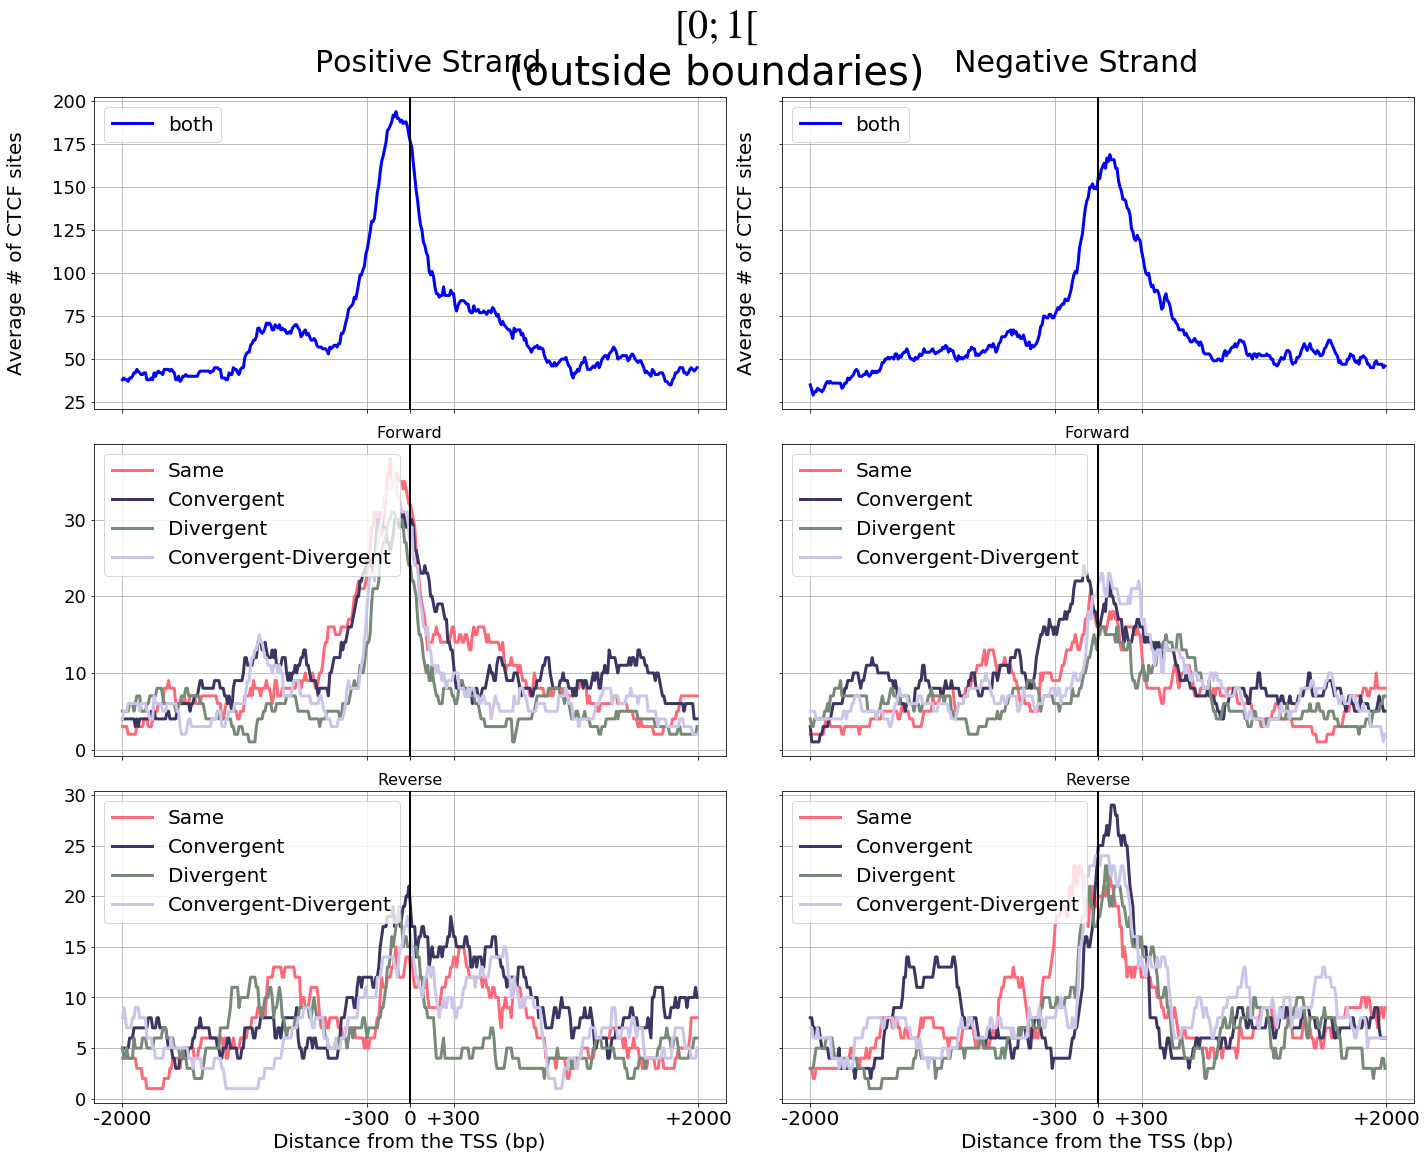

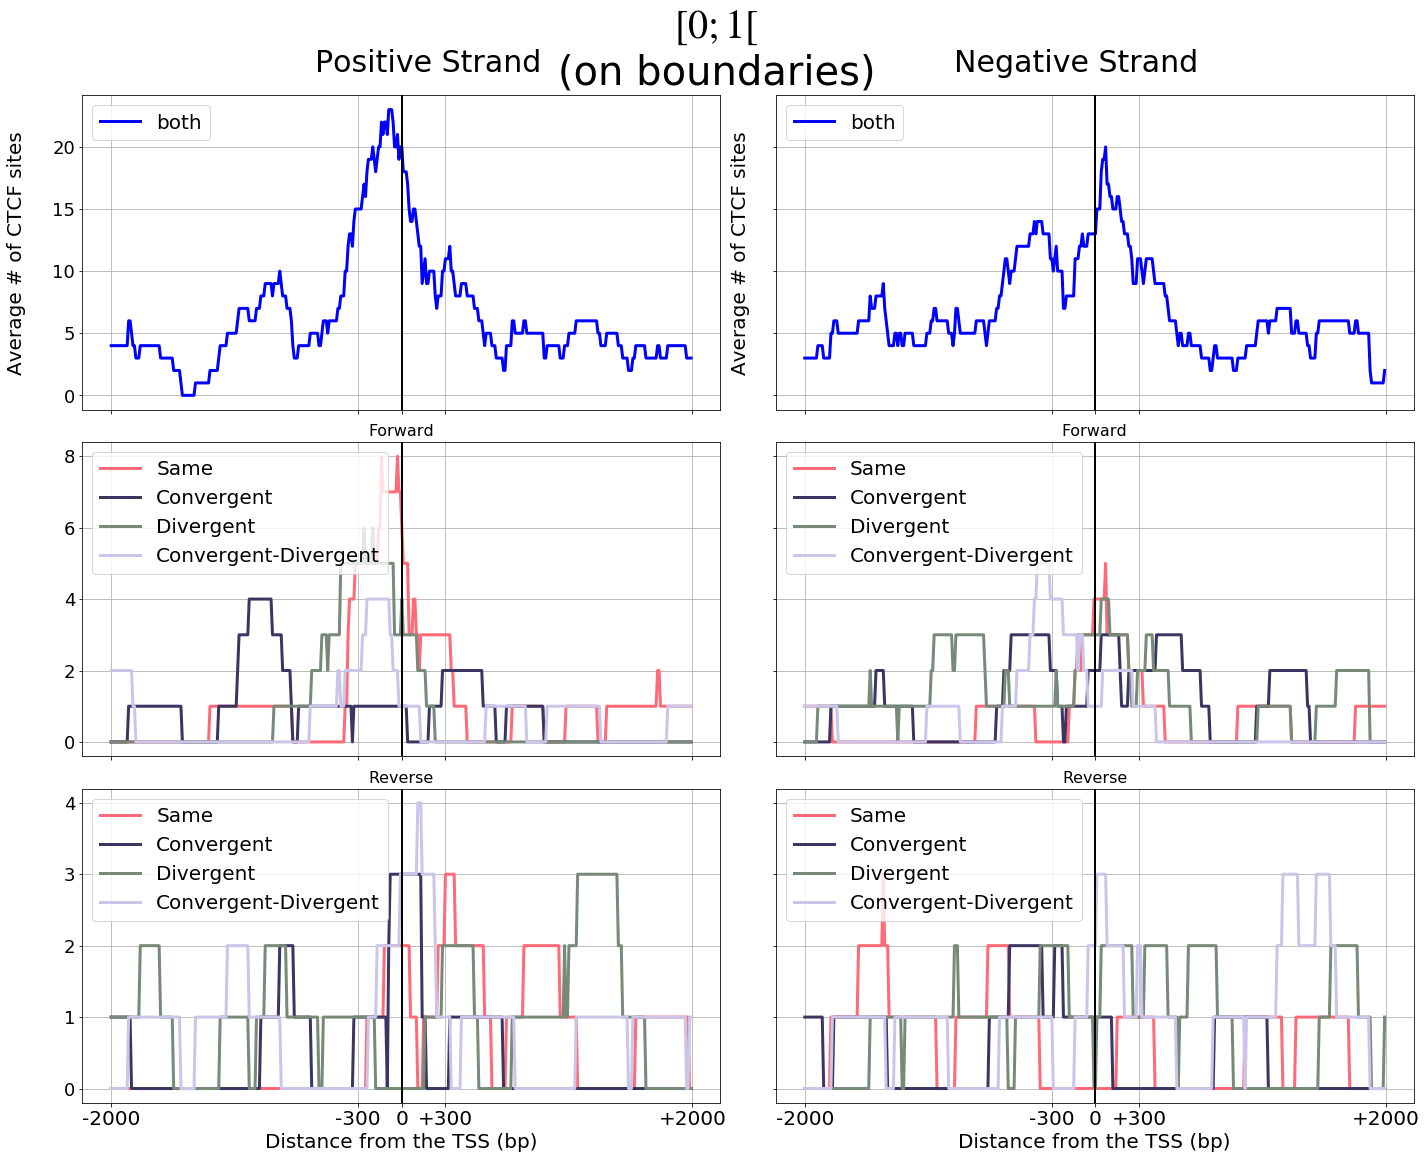

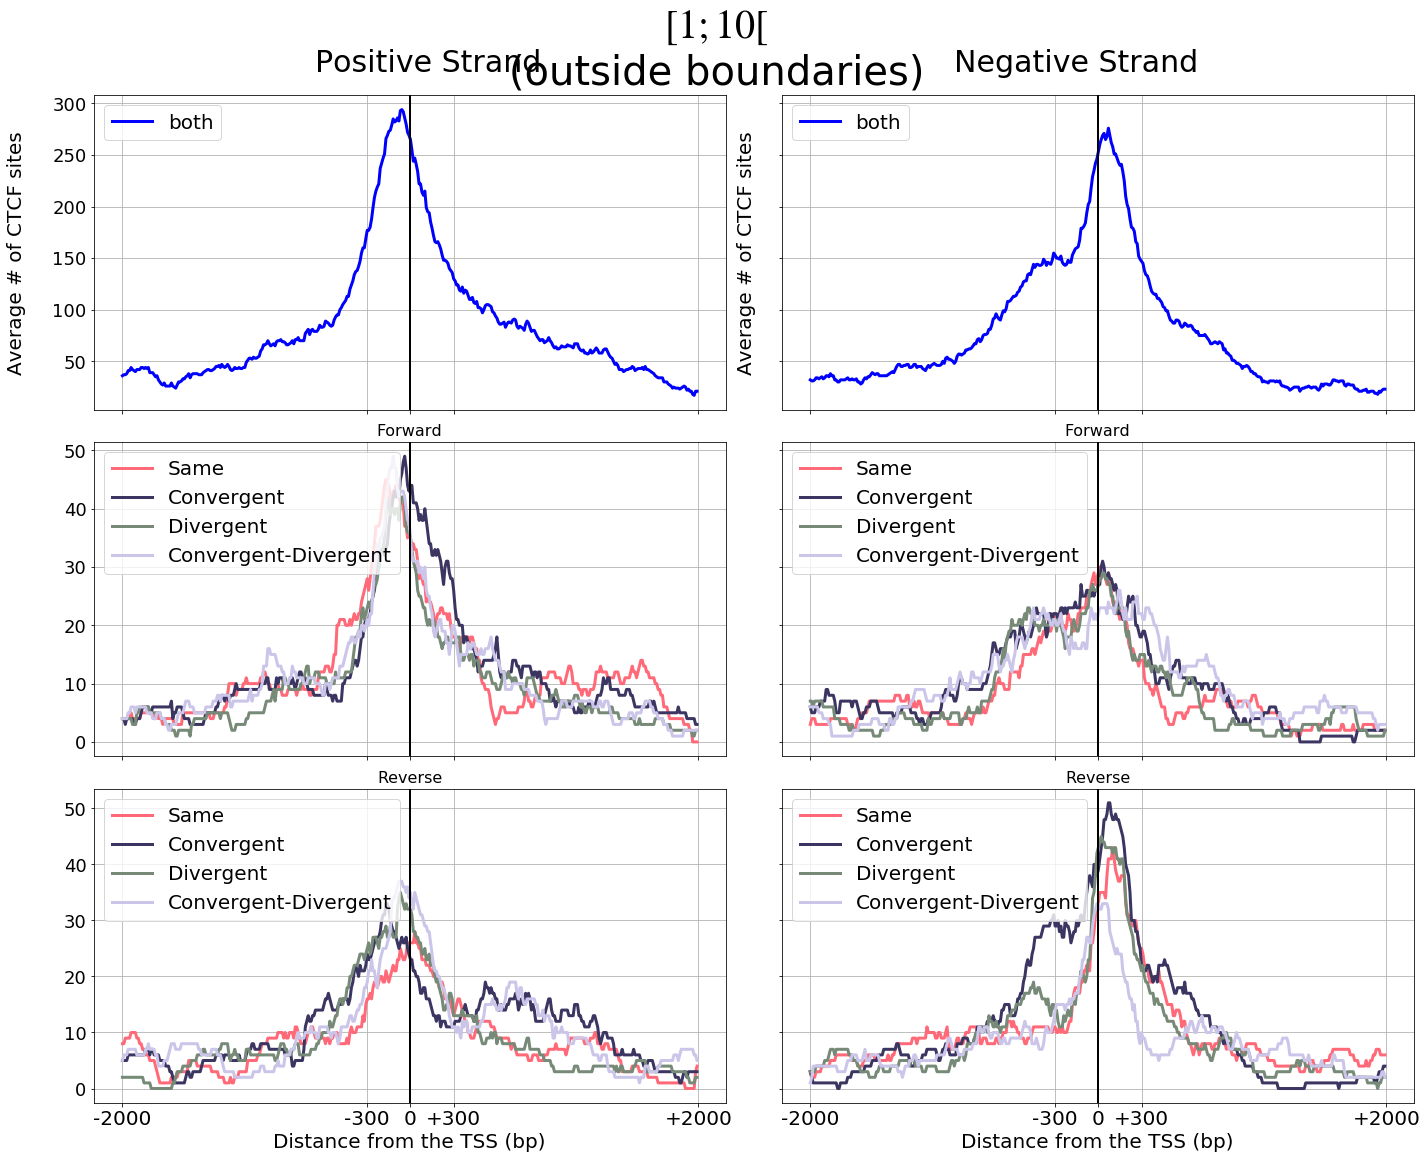

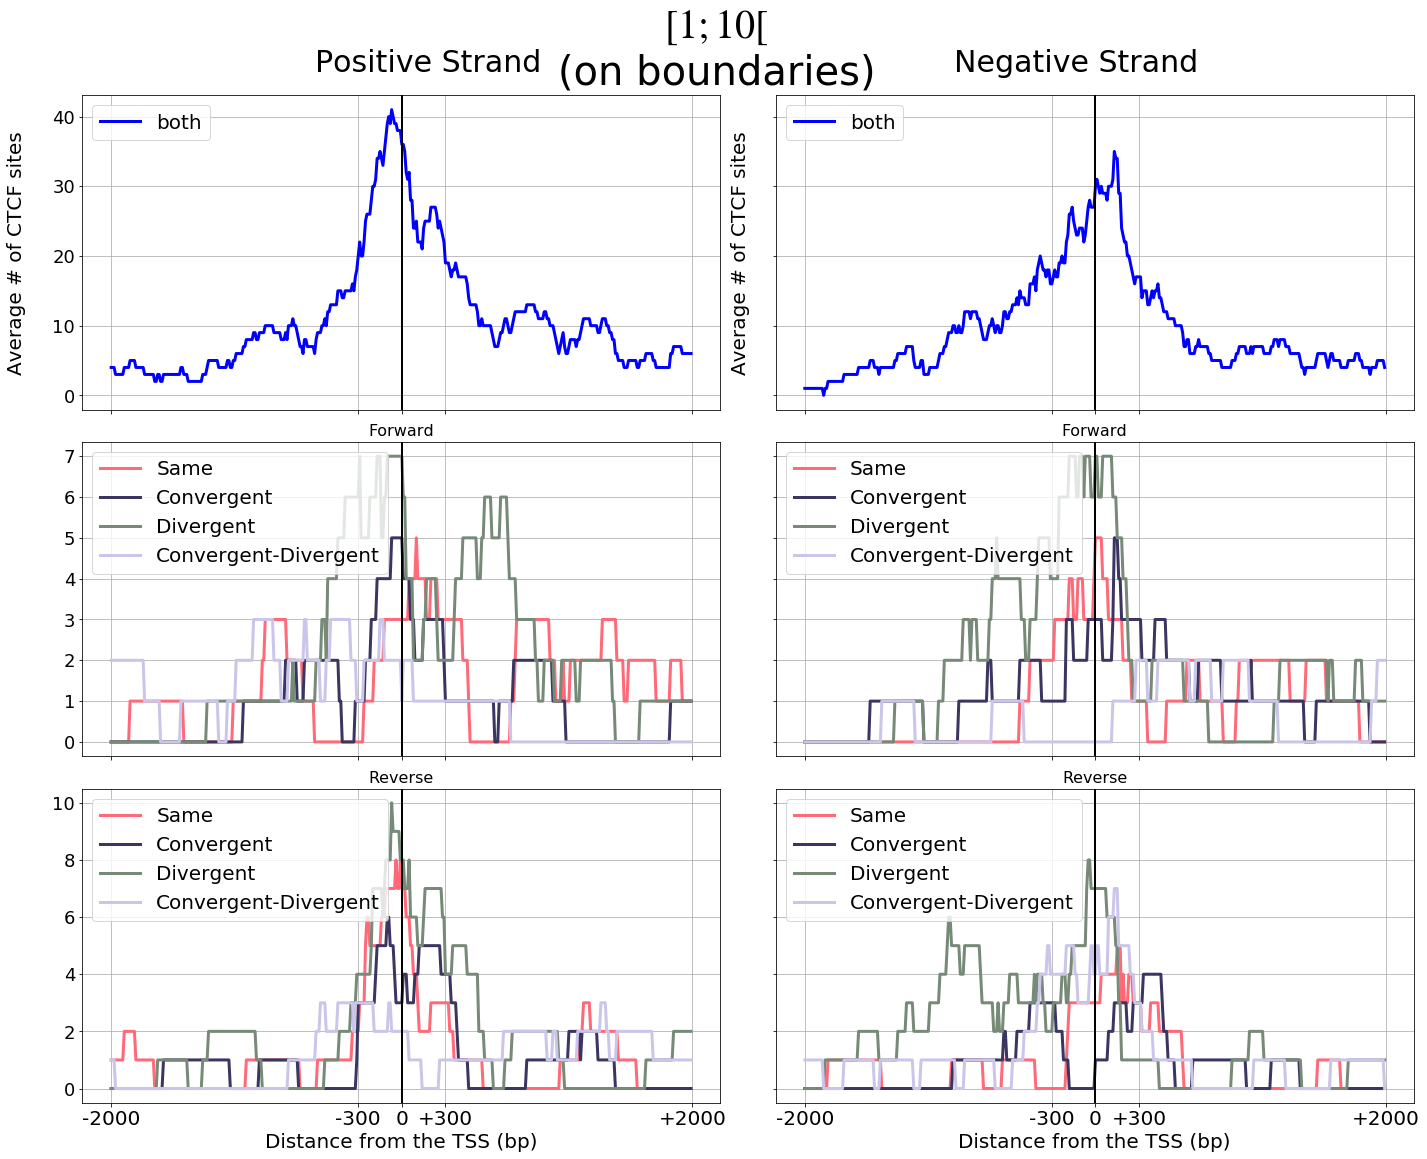

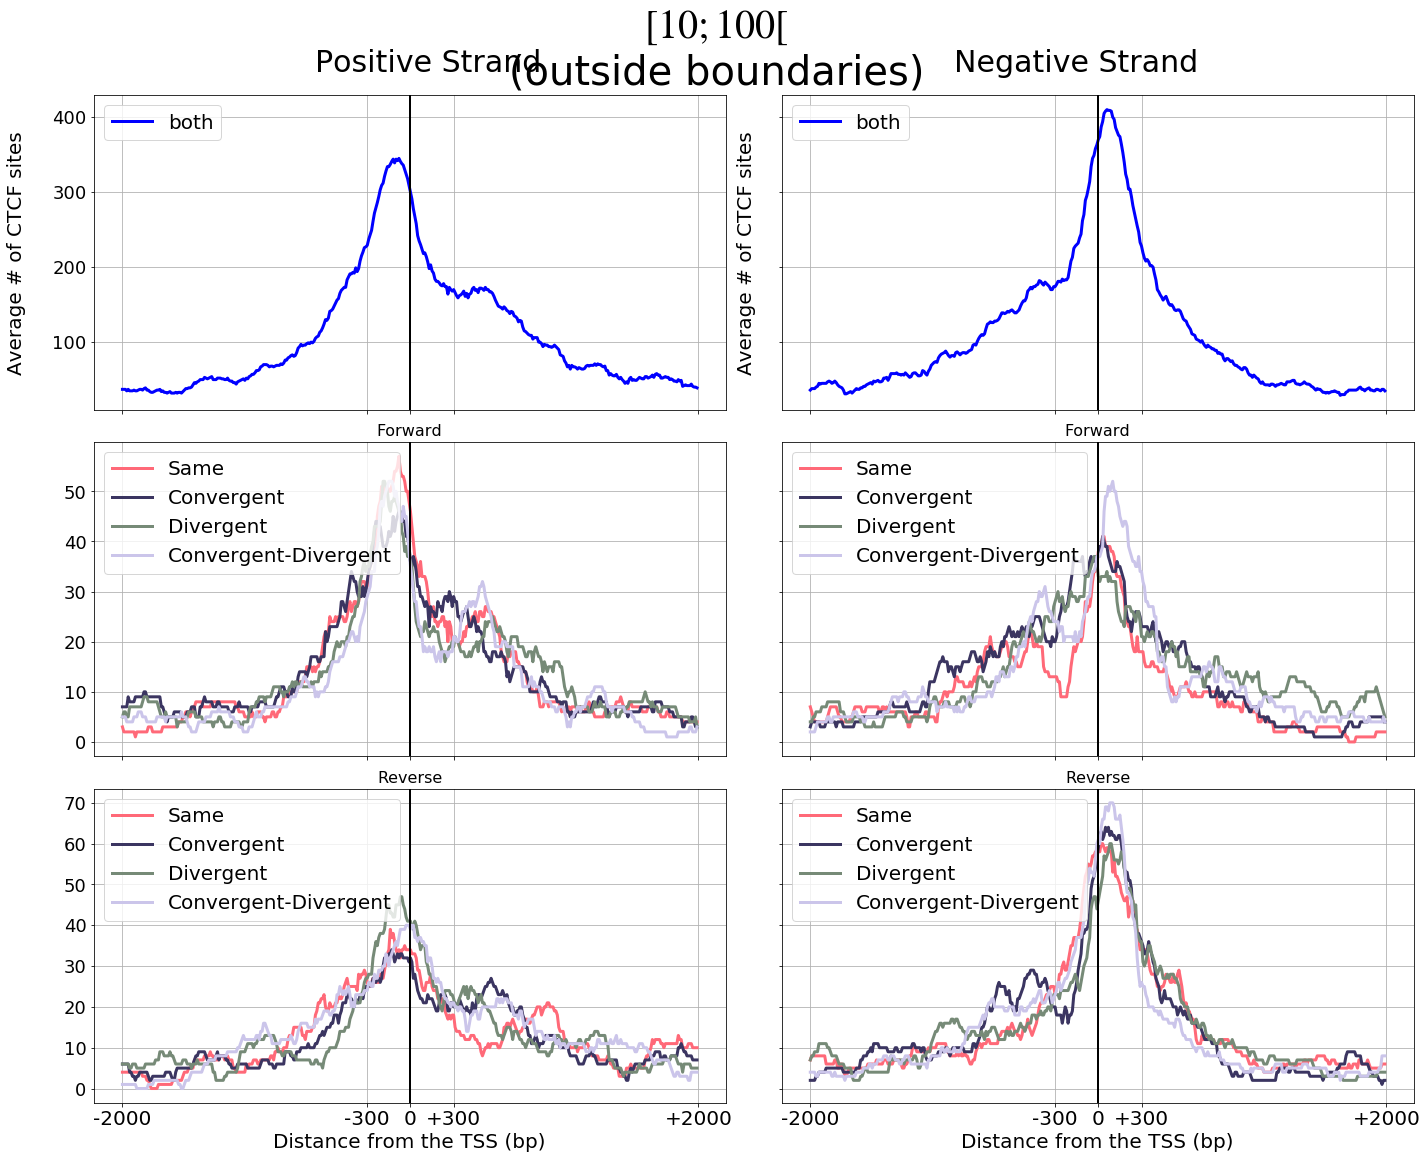

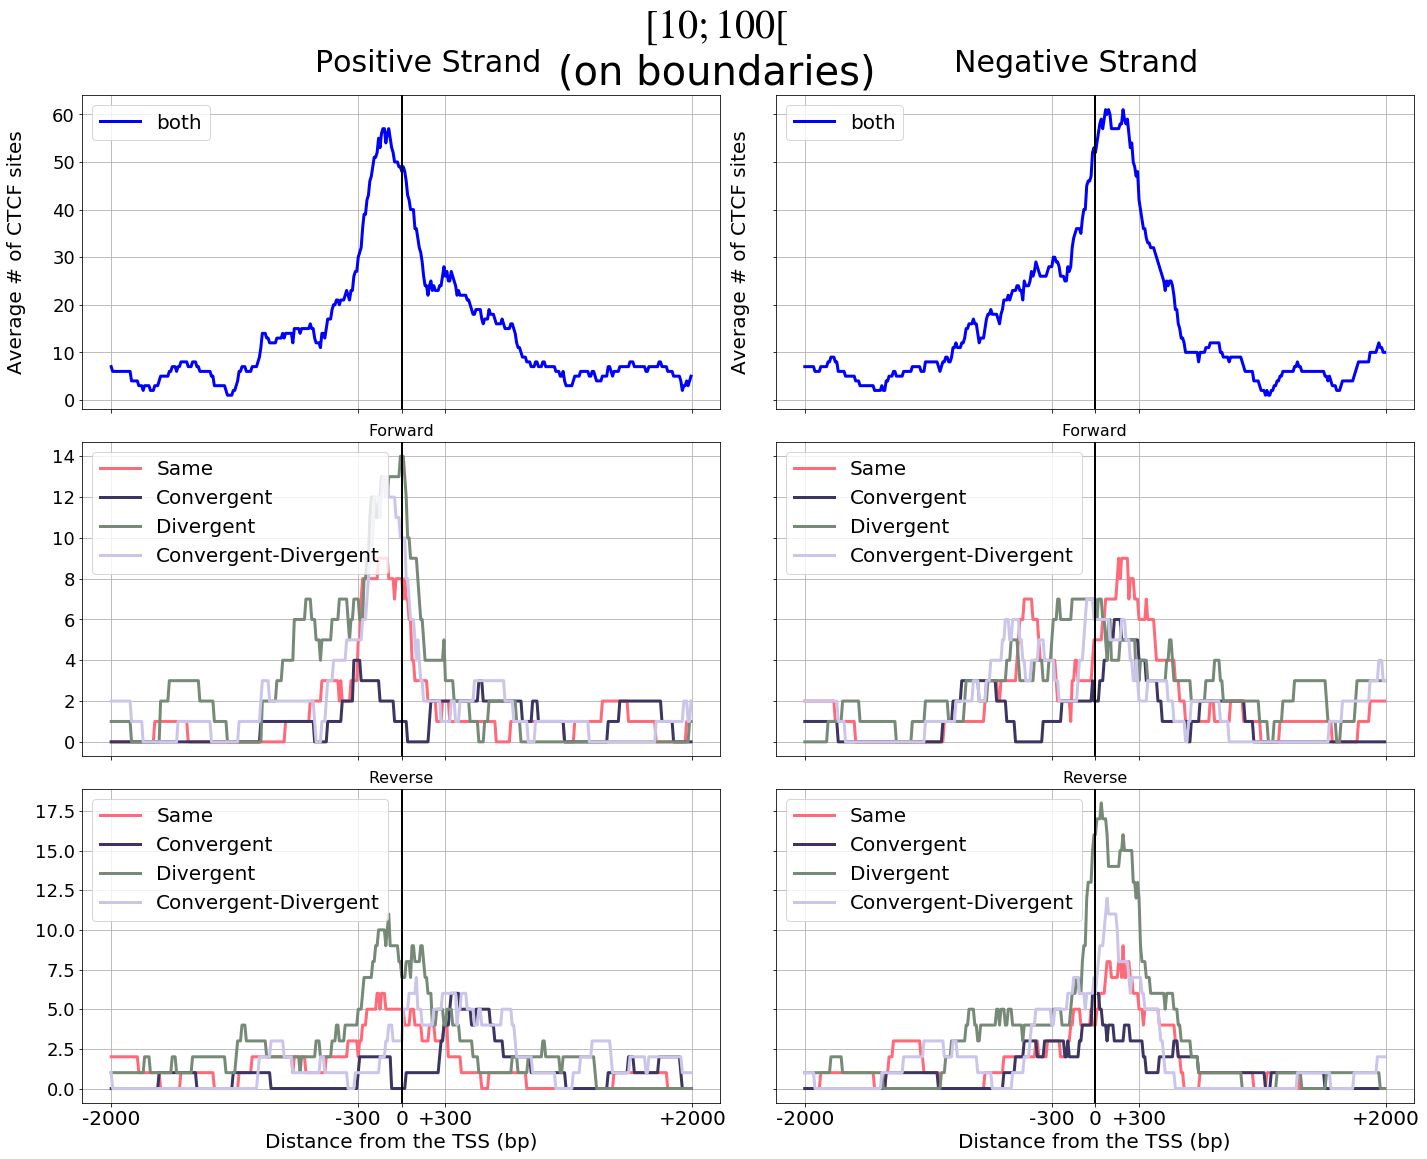

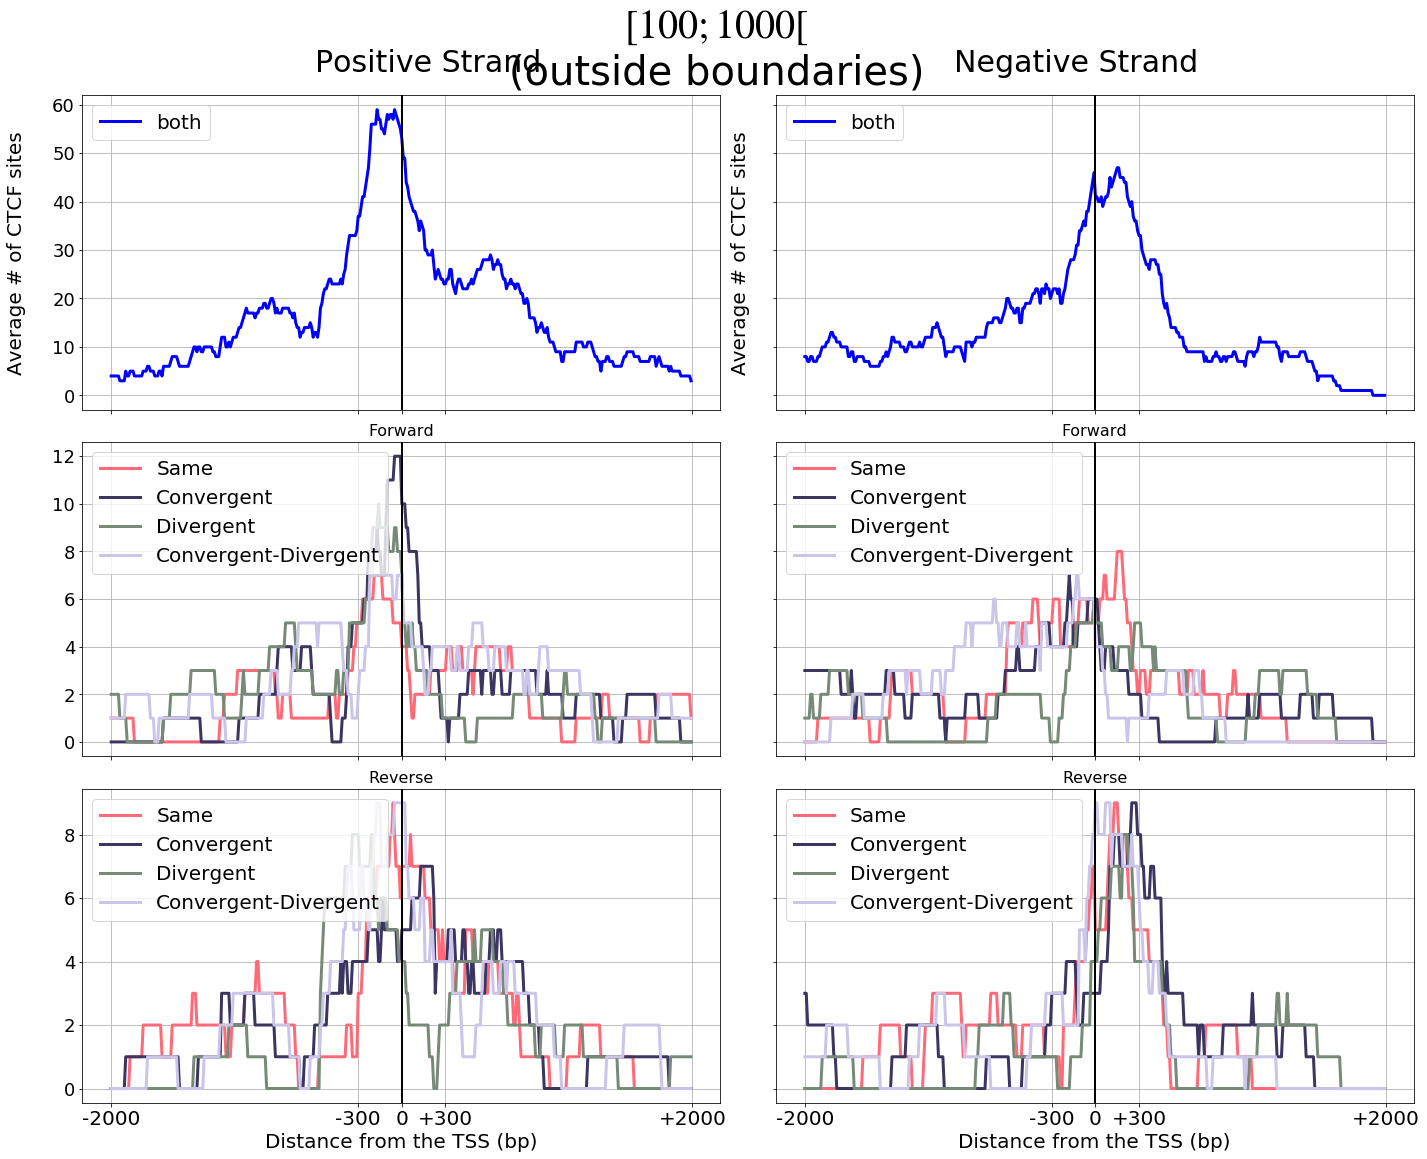

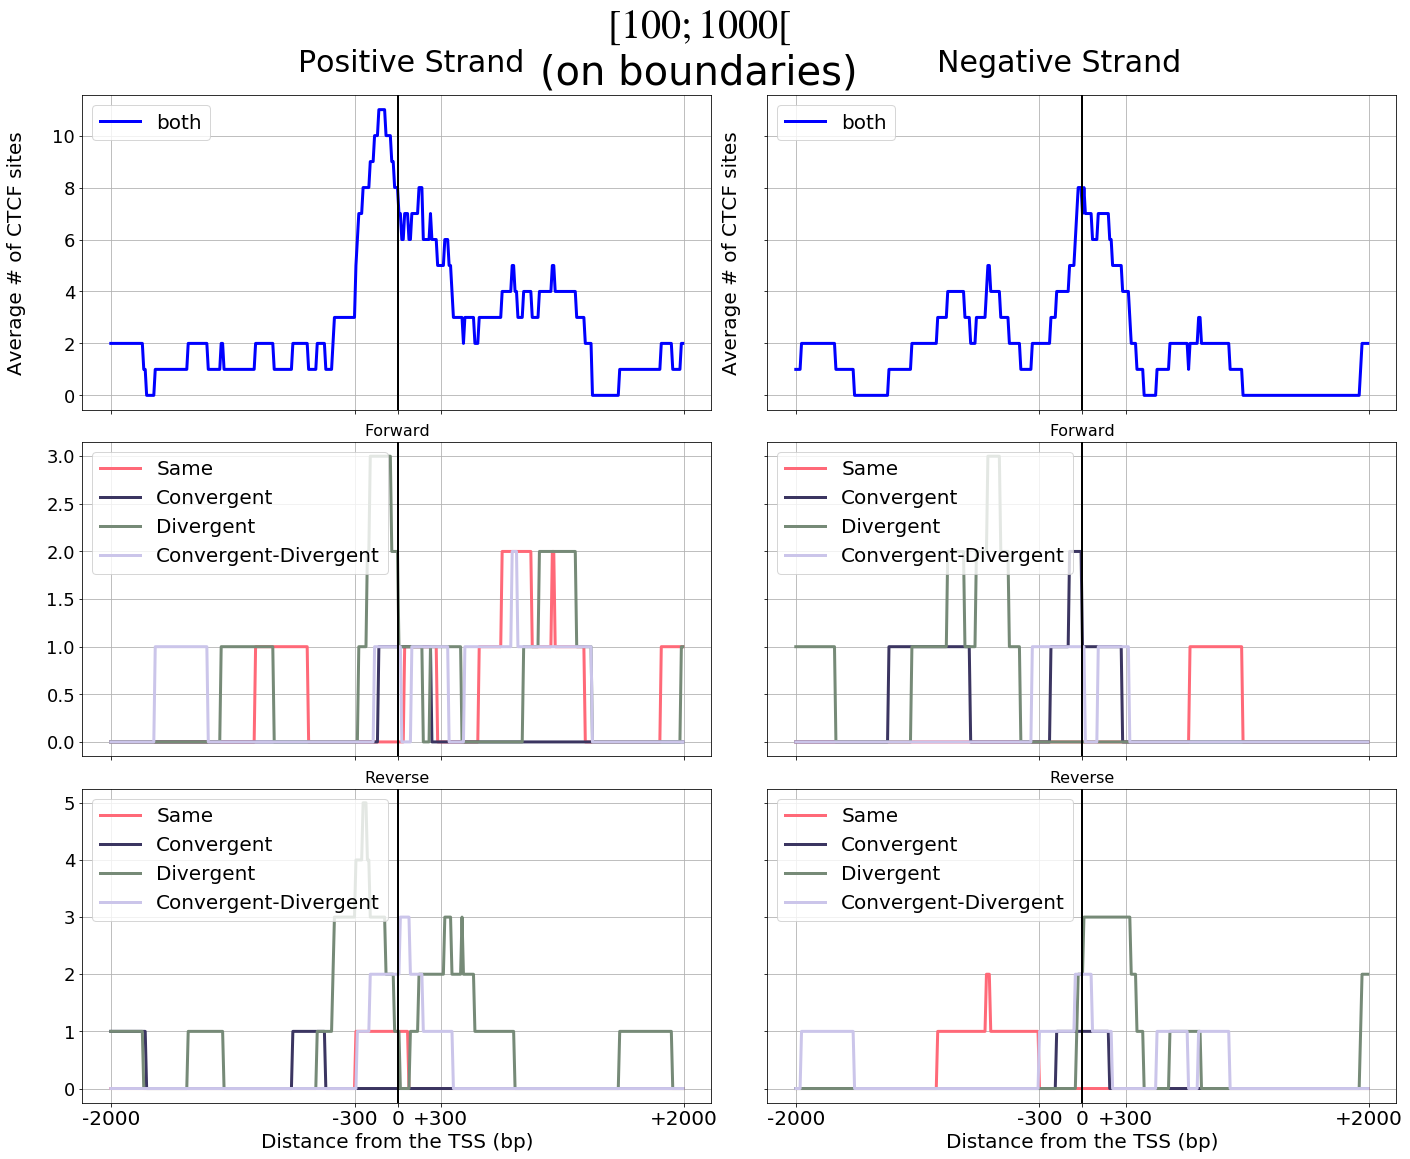

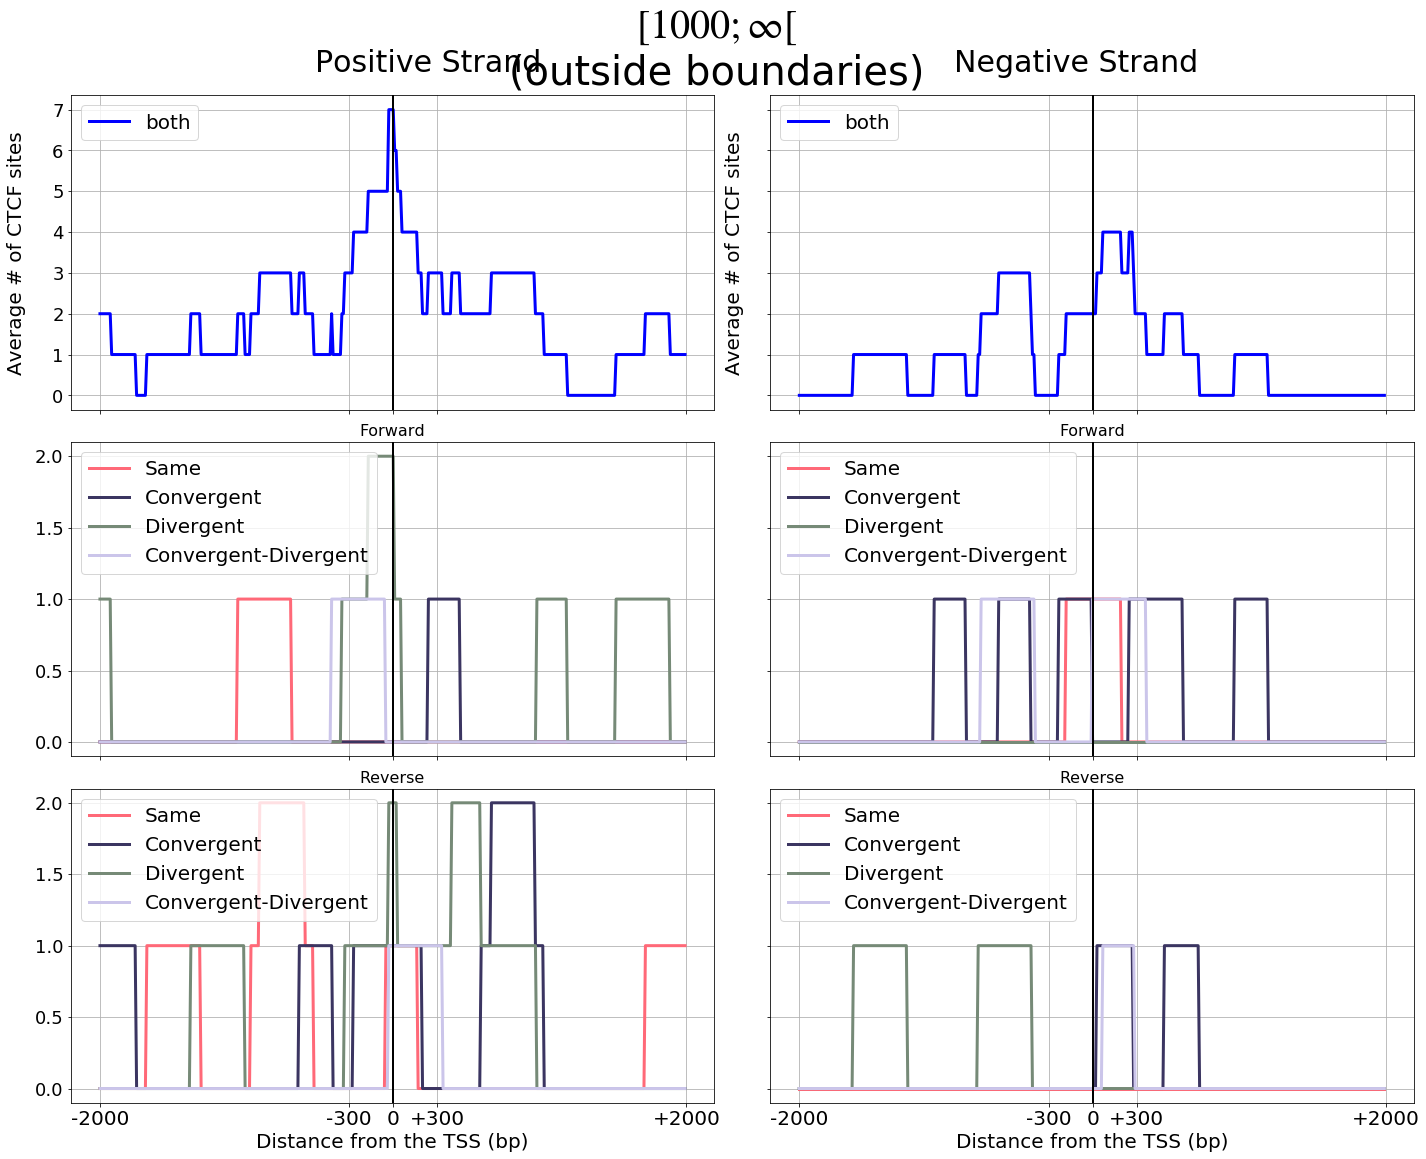

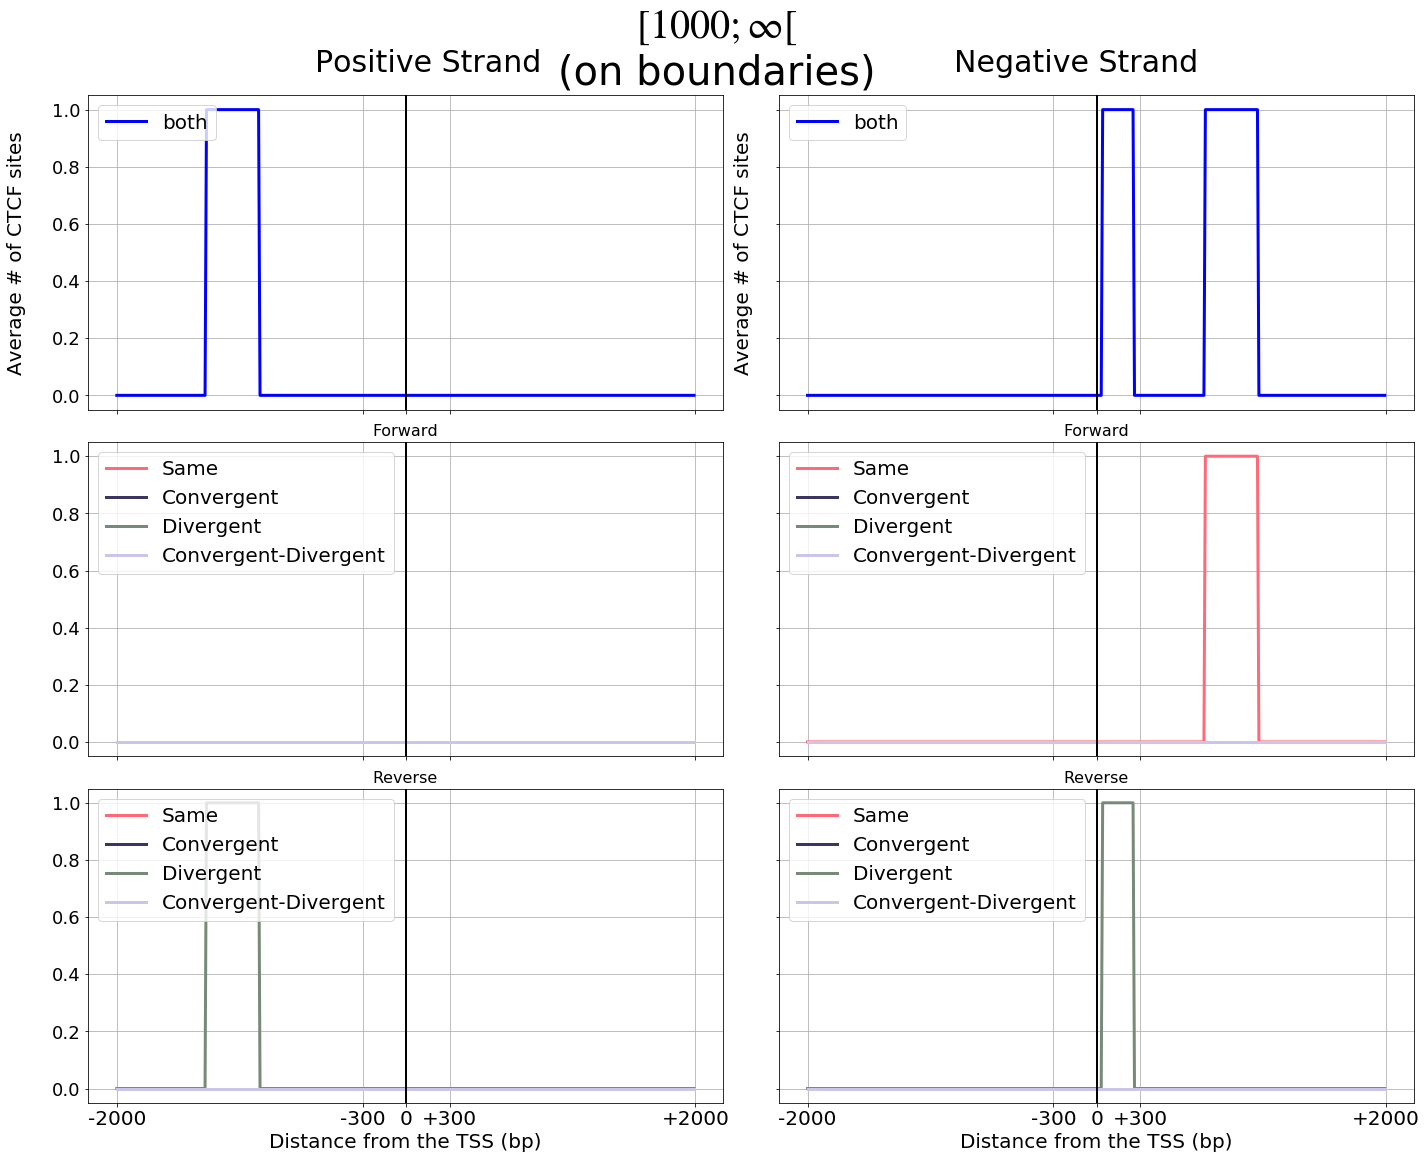

In [28]:
for c in genexp.rpkm_class_name.unique():
    gg = tss_with_boundaries[tss_with_boundaries.rpkm_class_name == c]
    gg_on_bounds = gg[gg.n_cell_types >= min_conservation].gene_uid.tolist()
    gg_outside_bounds = gg[gg.n_cell_types < min_conservation].gene_uid.tolist()
    
    fig, axes = pattern_stats(aggregations_by_gene, gg_outside_bounds)
#     axes[1,0].set_ylim(0, 0.05)
#     axes[2,0].set_ylim(0, 0.05)
    fig.suptitle(c + "\n(outside boundaries)", fontsize=40, x=0.5, y=1.07)
    
    fig, axes = pattern_stats(aggregations_by_gene, gg_on_bounds)
#     axes[1,0].set_ylim(0, 0.05)
#     axes[2,0].set_ylim(0, 0.05)
    fig.suptitle(c + "\n(on boundaries)", fontsize=40, x=0.5, y=1.07)
    
plt.show()

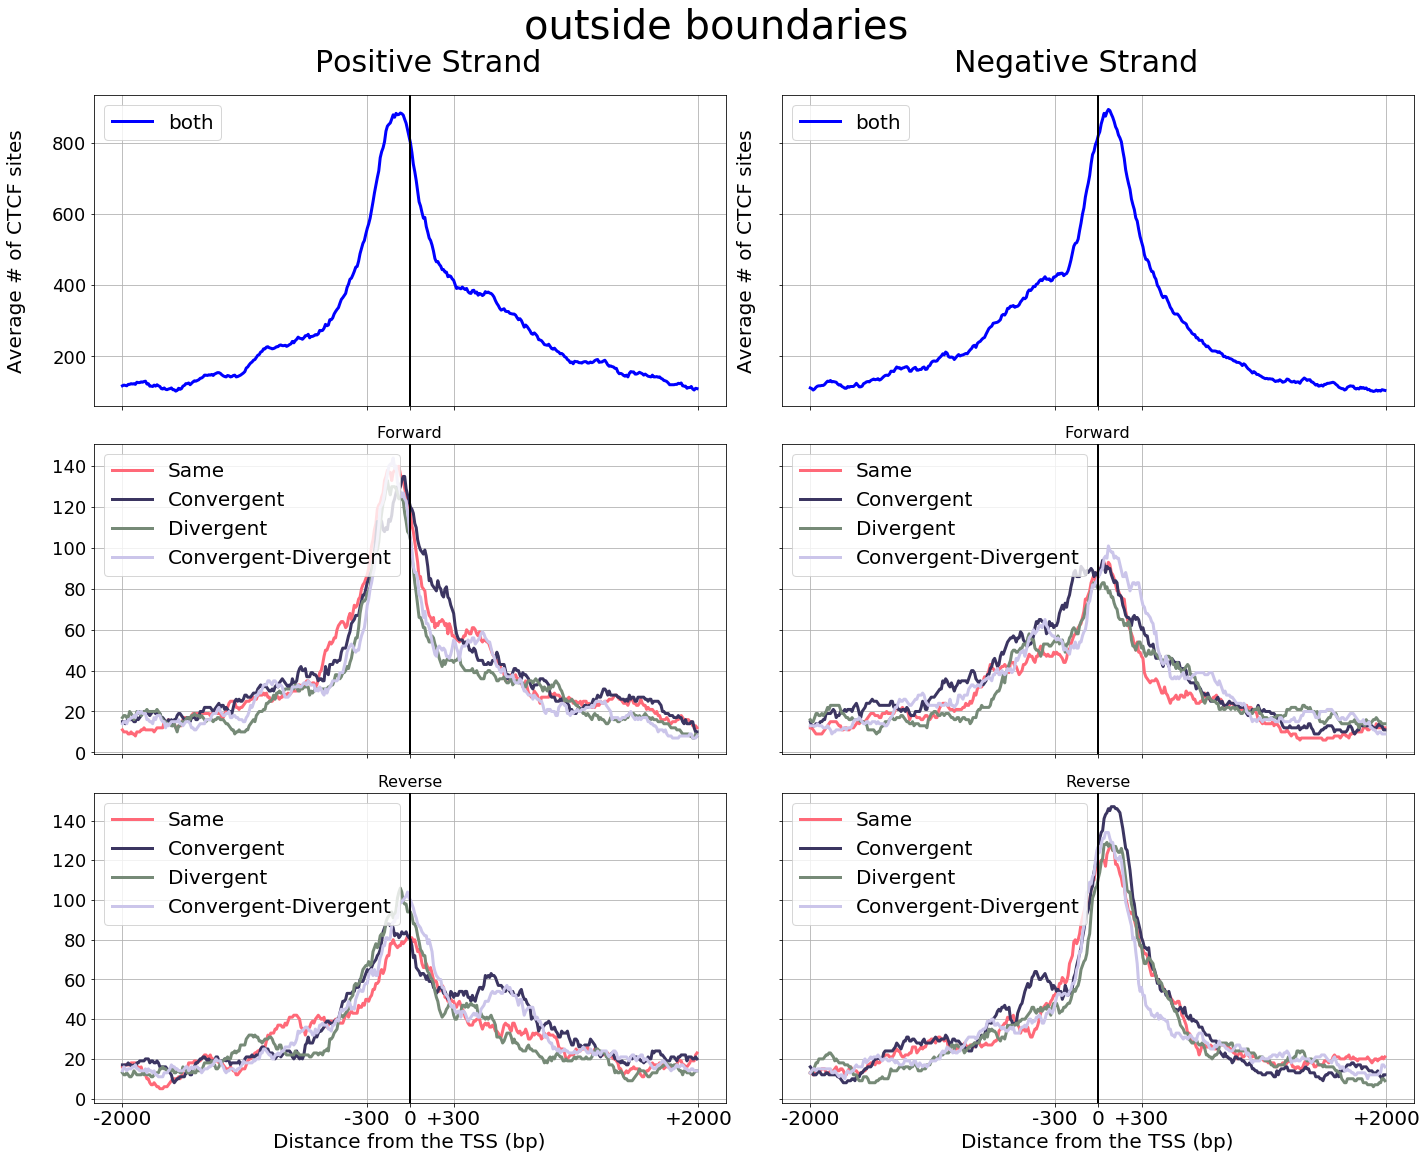

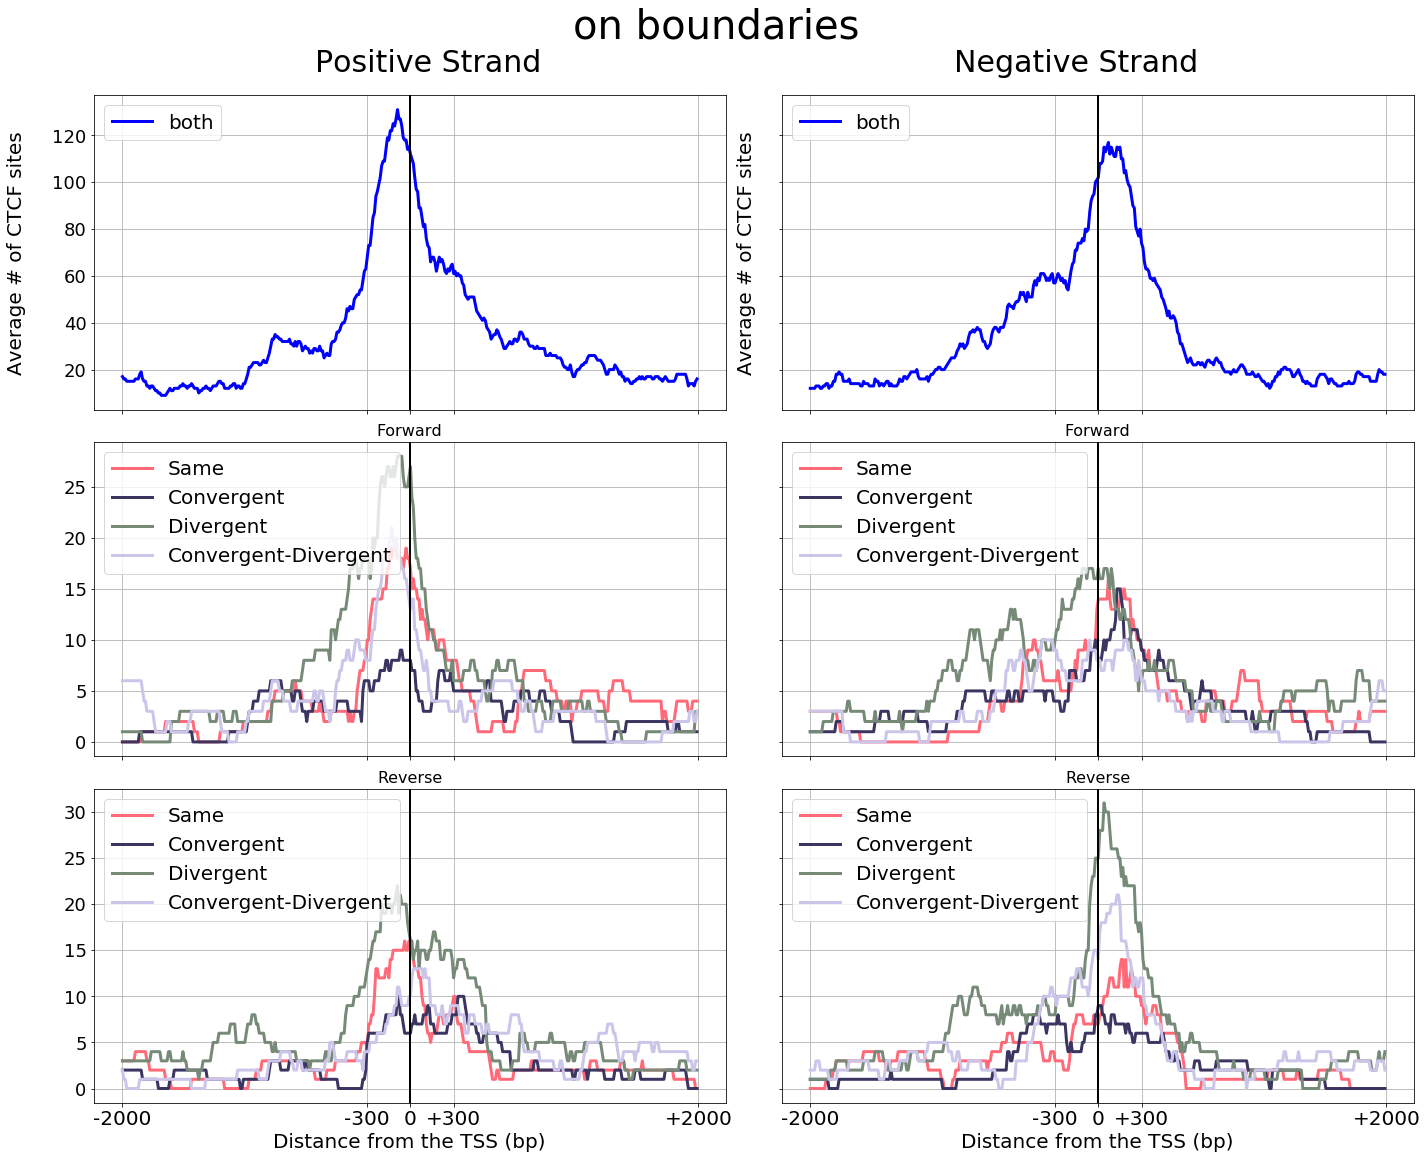

In [29]:
gg = tss_with_boundaries
gg_on_bounds = gg[gg.n_cell_types >= min_conservation].gene_uid.tolist()
gg_outside_bounds = gg[gg.n_cell_types < min_conservation].gene_uid.tolist()

fig, axes = pattern_stats(aggregations_by_gene, gg_outside_bounds)
# axes[1,0].set_ylim(0, 0.04)
# axes[2,0].set_ylim(0, 0.04)
fig.suptitle("outside boundaries", fontsize=40, x=0.5, y=1.07)

# print(len(gg_outside_bounds))

fig, axes = pattern_stats(aggregations_by_gene, gg_on_bounds)
# axes[1,0].set_ylim(0, 0.04)
# axes[2,0].set_ylim(0, 0.04)
fig.suptitle("on boundaries", fontsize=40, x=0.5, y=1.07)


# print(len(gg_on_bounds))
plt.show()

### CTCF categorization based on promoters and boundaries

In [30]:
promoters = BedTool.from_dataframe(tss).slop(l=promoter_size, s=True, genome='hg19', r=0).sort().to_dataframe(names=tss.columns)
promoters.head()

chr   start     end  gene_uid rpkm_class_name strand
0  chr1  893964  895964        66       $[1; 10[$      +
1  chr1  894636  896636        65     $[10; 100[$      -
2  chr1  899877  901877        67        $[0; 1[$      +
3  chr1  935491  937491        69        $[0; 1[$      -
4  chr1  953500  955500        73       $[1; 10[$      +

In [31]:
consensus_boundaries.loc[4]['boundary_uid']

'nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002_start,nCD8_0000_start'

In [33]:
ctcfs_with_features = BedTool.from_dataframe(ctcfs).map(BedTool.from_dataframe(consensus_boundaries).slop(b=25000, genome='hg19'), c=6, o='max', null=0)\
                                .map(BedTool.from_dataframe(promoters), c=4, o='count')\
                                .to_dataframe(names=ctcfs.columns.tolist() + ['n_cell_types', 'n_promoters'])
ctcfs_with_features.head()

chr   start     end orientation context  reverse  forward  C  CD  D  ...  \
0  chr1  237593  237953           >       T        0        1  0   0  0  ...   
1  chr1  521337  521697           >       S        0        1  0   0  0  ...   
2  chr1  714087  714447           >       S        0        1  0   0  0  ...   
3  chr1  805232  805362           >       S        0        1  0   0  0  ...   
4  chr1  839966  840326           >       S        0        1  0   0  0  ...   

   >CD  >D  >S  >T  ctcf_id  MotifScore  ChipSeqScore  rank_score_aggregate  \
0    0   0   0   1        0    9.790746     12.639115          1.502743e+09   
1    0   0   1   0        1   10.259412     13.836791          1.680162e+09   
2    0   0   1   0        2    9.893988      9.326291          1.342770e+09   
3    0   0   1   0        3   14.365820     46.641218          3.446545e+09   
4    0   0   1   0        4   16.393501     60.468042          3.756117e+09   

   n_cell_types  n_promoters  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             0            0  

[5 rows x 28 columns]

In [34]:
ctcfs_with_features['on_boundary'] = ctcfs_with_features.n_cell_types >= 2
ctcfs_with_features['on_promoter'] = ctcfs_with_features.n_promoters > 0

In [39]:
def __name_site(x):
    feats = []
    if x.on_boundary:
        feats.append("Boundary")
    if x.on_promoter:
        feats.append("Promoter")
    if len(feats) == 0:
        feats.append("None")
    return "-".join(feats)

ctcfs_with_features['cat'] = ctcfs_with_features.apply(__name_site, axis=1)
ctcfs_with_features.head()

chr   start     end orientation context  reverse  forward  C  CD  D  ...  \
0  chr1  237593  237953           >       T        0        1  0   0  0  ...   
1  chr1  521337  521697           >       S        0        1  0   0  0  ...   
2  chr1  714087  714447           >       S        0        1  0   0  0  ...   
3  chr1  805232  805362           >       S        0        1  0   0  0  ...   
4  chr1  839966  840326           >       S        0        1  0   0  0  ...   

   >T  ctcf_id  MotifScore  ChipSeqScore  rank_score_aggregate  n_cell_types  \
0   1        0    9.790746     12.639115          1.502743e+09             0   
1   0        1   10.259412     13.836791          1.680162e+09             0   
2   0        2    9.893988      9.326291          1.342770e+09             0   
3   0        3   14.365820     46.641218          3.446545e+09             0   
4   0        4   16.393501     60.468042          3.756117e+09             0   

   n_promoters  on_boundary  on_promoter   cat  
0            0        False        False  None  
1            0        False        False  None  
2            0        False        False  None  
3            0        False        False  None  
4            0        False        False  None  

[5 rows x 31 columns]

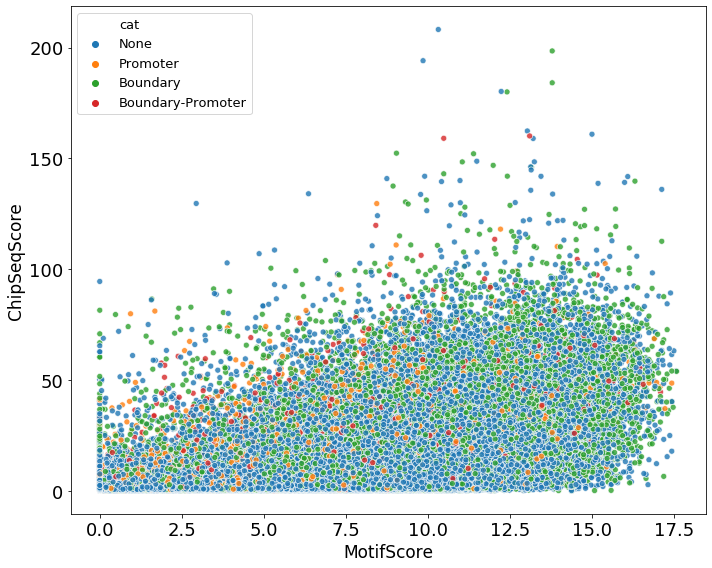

In [49]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=ctcfs_with_features, x='MotifScore', y='ChipSeqScore', hue='cat', alpha=0.8)
plt.show()

In [57]:
from scipy.stats import spearmanr

Spearman
SpearmanrResult(correlation=0.5106031014561009, pvalue=0.0)
Pearson
              MotifScore  ChipSeqScore
MotifScore      1.000000      0.445596
ChipSeqScore    0.445596      1.000000


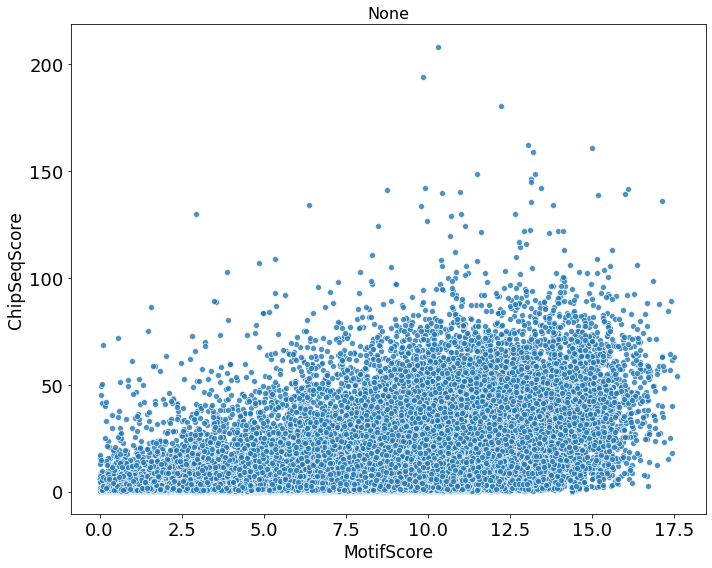

Spearman
SpearmanrResult(correlation=0.47864839551364474, pvalue=2.267643127860094e-175)
Pearson
              MotifScore  ChipSeqScore
MotifScore       1.00000       0.47089
ChipSeqScore     0.47089       1.00000


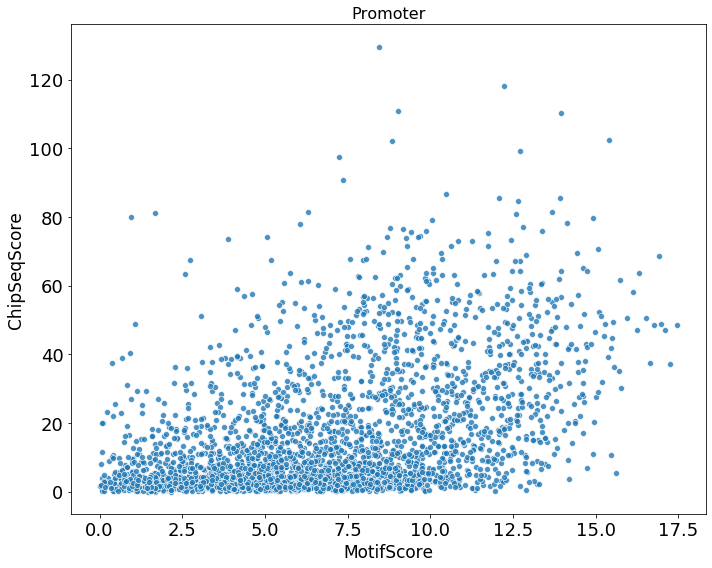

Spearman
SpearmanrResult(correlation=0.5314471498663694, pvalue=0.0)
Pearson
              MotifScore  ChipSeqScore
MotifScore      1.000000      0.453385
ChipSeqScore    0.453385      1.000000


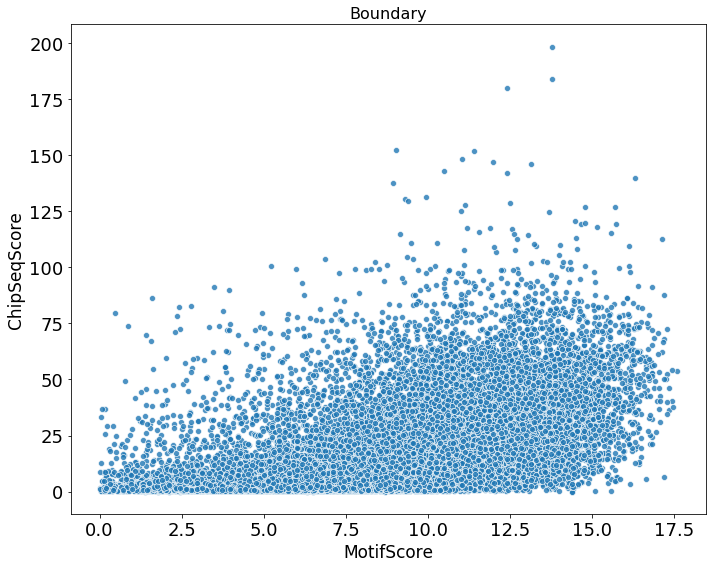

Spearman
SpearmanrResult(correlation=0.5339973994528068, pvalue=5.213413361575912e-116)
Pearson
              MotifScore  ChipSeqScore
MotifScore      1.000000      0.503593
ChipSeqScore    0.503593      1.000000


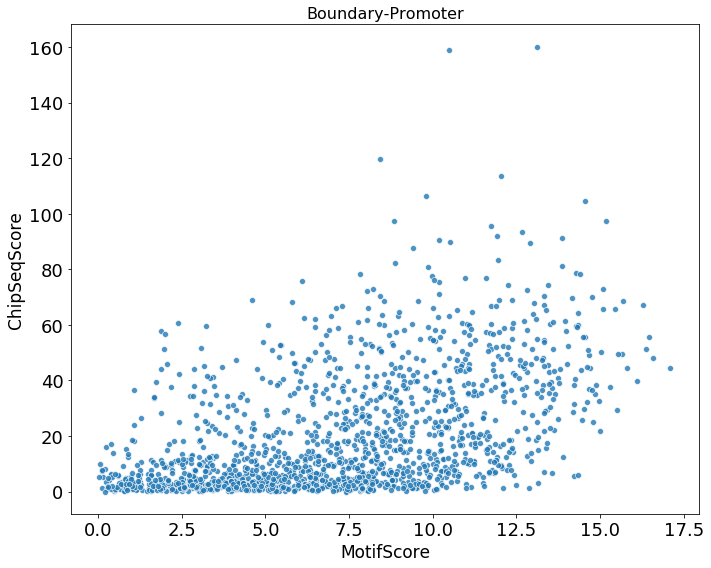

In [61]:
for cat in ctcfs_with_features.cat.unique():
    plt.figure(figsize=(10, 8))
    x = ctcfs_with_features[(ctcfs_with_features.cat == cat) & (ctcfs_with_features.MotifScore > 0) & (ctcfs_with_features.ChipSeqScore > 0)]
    sns.scatterplot(data=x, x='MotifScore', y='ChipSeqScore', alpha=0.8)
    
    print("Spearman")
    print(spearmanr(x.MotifScore, x.ChipSeqScore))
    print("Pearson")
    print(x[['MotifScore', 'ChipSeqScore']].corr())
    
    plt.title(cat)
    plt.show()

Text(0, 0.5, 'Aggregated rank\nscore (x $10^9$)')

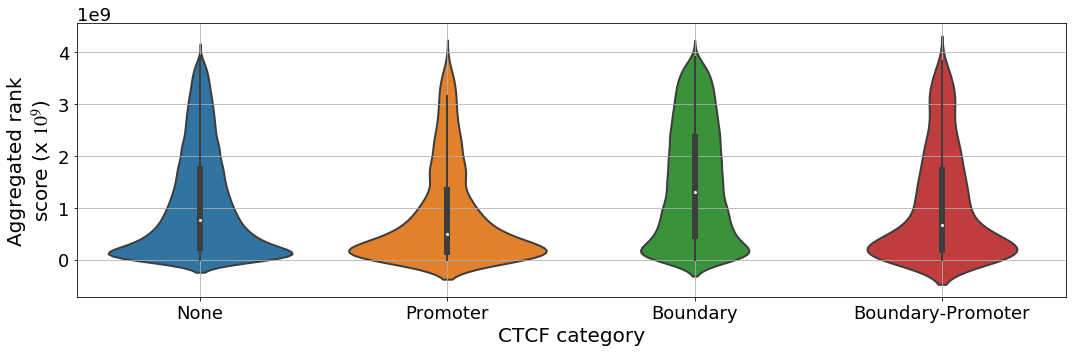

In [70]:
plt.figure(figsize=(15, 5))
sns.violinplot(data=ctcfs_with_features, x='cat', y='rank_score_aggregate')
plt.grid()
plt.xlabel("CTCF category", fontsize=20)
plt.ylabel("Aggregated rank\nscore (x $10^9$)", fontsize=20)